In [3]:
import os
# Set the environment variable
os.environ['STPSF_PATH'] = os.path.abspath("/home/yuchialin/JWST/stpsf_data")
#os.environ['WEBBPSF_EXT_PATH'] = os.path.abspath("stpsf_data")
#os.environ['PYSYN_CDBS'] = os.path.abspath("webbpsf_ext_data/cdbs")
#os.environ['CRDS_PATH'] = os.path.abspath("crds_cache")
#os.environ['CRDS_SERVER_URL'] = "https://jwst-crds.stsci.edu"

# Verify the variable is set
print("STPSF_PATH:", os.environ['STPSF_PATH'])
print("WEBBPSF_EXT_PATH:", os.environ['WEBBPSF_EXT_PATH'])
print("PYSYN_CDBS:", os.environ['PYSYN_CDBS'])
print("CRDS_PATH:", os.environ['CRDS_PATH'])

STPSF_PATH: /home/yuchialin/JWST/stpsf_data
WEBBPSF_EXT_PATH: /home/yuchialin/JWST/stpsf_data
PYSYN_CDBS: /home/yuchialin/JWST/webbpsf_ext_data/cdbs
CRDS_PATH: /home/yuchialin/JWST/crds_cache


In [4]:
# Imports
from IPython.display import display, HTML

def setup_display(width=95, fontsize=16):
    """
    Sets window width and markdown fontsize for Jupyter notebook. Width is % of window.
    """
    display(HTML("<style>.container { width:"+str(width)+"% !important; }</style>"))
    display(HTML("<style>.rendered_html { font-size: "+str(fontsize)+"px; }</style>"))
    return None

def source(fn):
    import inspect
    print(inspect.getsource(fn))
    return None

import numpy as np
import glob
import winnie
from winnie.plot import animate_quick_implot, quick_implot, mpl, plt
from spaceKLIP import database
import webbpsf
import astropy.units as u

plt.style.use('winnie.winnie_mplstyle') # Comment this out or replace it if you prefer a different plot style

setup_display()

In [5]:
# Prep the SpaceRDI object:
distance = 60.1 # Distance to your target in parsecs

base_dir = 'data_twhya_winnie/'
input_dir = f'{base_dir}padded/'
data_ext = 'calints'
fitsfiles = np.sort(glob.glob(f'{input_dir}*{data_ext}.fits')) # Populate a file list

In [6]:
# Initialize the spaceKLIP database
Database = database.Database(base_dir)
Database.verbose = False
Database.read_jwst_s012_data(datapaths=fitsfiles)

# Create the SpaceRDI object we'll use to carry out RDI
wdb = winnie.SpaceRDI(Database, output_subdir='WinnieRDI', overwrite=True, verbose=True, pad_data='auto')

In [7]:
# Task 3: Add artifact and apply ref_mask
wdb.load_concat(0)
bad_ind = 3
fake_artifact = np.where(winnie.utils.dist_to_pt([123,248], wdb.nx, wdb.ny) < 2.5, 5.0, 0.0)
wdb.imcube_ref[bad_ind] += fake_artifact

JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (650,650)
Reference data: 283 exposures of shape (650,650)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


In [8]:
# Create reference mask (Key Task3 integration)
ref_mask = np.ones((wdb.optzones.shape[0], wdb.imcube_ref.shape[0]), dtype=bool)
ref_mask[:, bad_ind] = False
wdb.set_fixed_rdi_settings(ref_mask=ref_mask)

In [9]:
# Task5: Prepare PSF convolution grid 
spec_synphot = webbpsf.specFromSpectralType('M0V', catalog='ck04')  # From Task2
try:
    wdb.prepare_convolution(spec_synphot, fov_pixels=201, osamp=2)
except Exception as e:
    print(f"PSF prep failed: {e}")
    wdb.prepare_convolution(None, fov_pixels=201, osamp=2)  # Fallback

Setting up sim to match data_twhya_winnie/padded/jw01179005001_03107_00001_nrcalong_calints.fits

MAST OPD query around UTC: 2024-02-14T10:22:56.036
                        MJD: 60354.43259300926

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2024021301-NRCA3_FP1-1.fits
	Date (MJD):	 60353.2554
	Delta time:	 -1.1772 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/O2024021601-NRCA3_FP1-1.fits
	Date (MJD):	 60355.7958
	Delta time:	 1.3633 days
User requested choosing OPD time closest in time to 2024-02-14T10:22:56.036, which is O2024021301-NRCA3_FP1-1.fits, delta time -1.177 days
Importing and format-converting OPD from /home/yuchialin/JWST/stpsf_data/MAST_JWST_WSS_OPDs/O2024021301-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point (NRCA3_FP1)

Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F444W
    Detector: NRCA5
    Apername: NRCA5_MASK335R
    Det. Pos.: (150, 174

In [10]:
# Run HPFRDI with ref_mask (Task3's contribution)
wdb.hpfrdi_presets()
hpfrdi_reduc = wdb.run_rdi() 

JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (650,650)
Reference data: 283 exposures of shape (650,650)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x719287465620>
'opt_smoothing_kwargs': {'filtersize': 1.197928007385561}
'ref_mask': <class 'numpy.ndarray'> of shape (1, 283)
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


In [11]:
# Enhanced deconvolution setup (From Task5)
reduc_in = None # for None, run_deconvolution will run a simple HPFRDI reduction and use that for deconvolution
num_iter = 200
return_iters = np.concatenate([np.arange(1,10), np.arange(10,num_iter+1,10)])
excl_mask = winnie.utils.px_size_to_ang_size(
    winnie.utils.dist_to_pt(wdb.c_star, wdb.nx, wdb.ny),
    wdb.pxscale
).value > 7

# Run deconvolution on HPFRDI with artifact mitigation (Combined core)
deconv_reduc = wdb.run_deconvolution(reduc_in, num_iter=num_iter, auto_eps_errtol=0.05, 
                            return_iters=return_iters, save_products=True,
                            show_progress=True, excl_mask_in=excl_mask,
                            init_from_reduc=True)

JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (650,650)
Reference data: 283 exposures of shape (650,650)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x719287465620>
'opt_smoothing_kwargs': {'filtersize': 1.197928007385561}
'ref_mask': <class 'numpy.ndarray'> of shape (1, 283)
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
info_str = "Unknown Filter/Wavelength"
pixel_scale_value = None
units = "arcsec"
try:
    # ... (load concat if needed) ...
    current_concat_key = wdb.concat
    # ... (get key string if needed) ...
    filter_name = wdb.database.obs[current_concat_key]['FILTER'][0]
    wavelength = wdb.database.obs[current_concat_key]['CWAVEL'][0]
    info_str = f"{filter_name} ({wavelength:.2f} µm)"

    # Get pixel scale
    pixel_scale_value = wdb.pxscale.to(u.arcsec/u.pixel).value

except NameError:
    print("Warning: 'wdb' object not found. Cannot add scale bar or filter info.")
except AttributeError:
     print("Warning: Could not find 'pxscale' attribute on 'wdb'. Cannot add scale bar.")
except Exception as e:
    print(f"Warning: Could not retrieve info dynamically ({e}). Scale bar or filter info might be missing.")

print(f"Pixel scale found: {pixel_scale_value} {units}/pixel")
print(f"Filter info: {info_str}")

Pixel scale found: 0.062424185 arcsec/pixel
Filter info: F444W (4.44 µm)


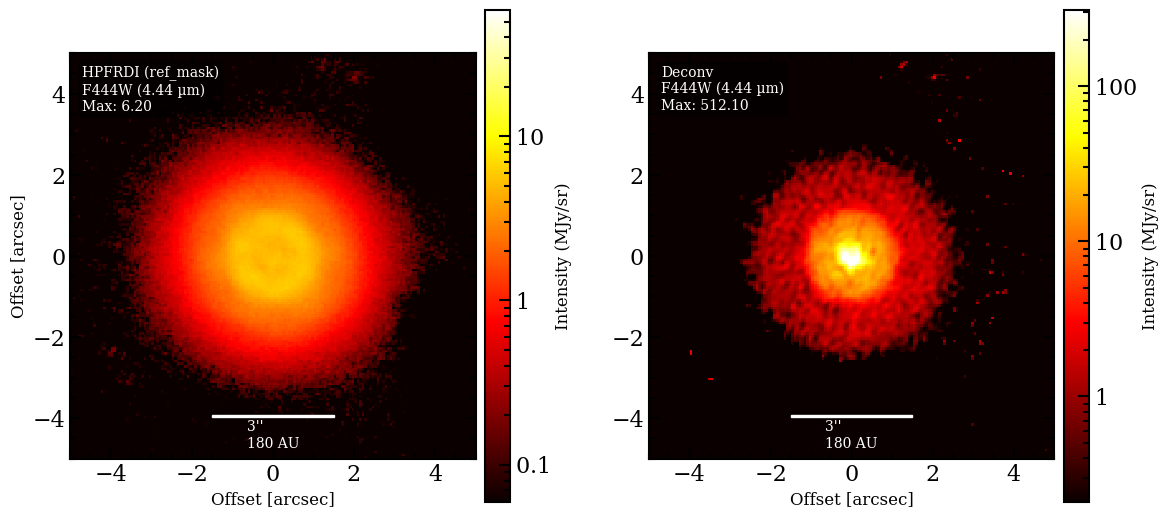

In [35]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # Import for scale bar
import matplotlib.font_manager as fm # Font properties for scale bar (optional)

images_to_plot = [deconv_reduc[1].im, deconv_reduc[0].im] # Use the deconvolved image and HPFRDI image
labels = ['HPFRDI (ref_mask)', 'Deconv']
# Create figure and axes for two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5)) # Adjusted figsize for colorbars
fontprops = fm.FontProperties(size=10) # Font properties for scale bar label
# Loop through each image/axis to plot individually
for i, ax in enumerate(axes):
    img_data = images_to_plot[i]

    # Calculate color limits for this specific image using the requested formula
    if i == 0:
        clim_low_raw, clim_high_raw = np.array([0.01, 10.0]) * np.nanpercentile(img_data, 99.975)
    else:
        clim_low_raw, clim_high_raw = np.array([0.001, 1.5]) * np.nanpercentile(img_data, 99.975)

    # Create LogNorm object, handling potential non-positive values robustly
    try:
        # Find minimum positive value if needed
        min_positive = np.nanmin(img_data[img_data > 0]) if np.any(img_data > 0) else None
        # Set vmin safely
        vmin_safe = max(clim_low_raw, min_positive) if min_positive is not None and clim_low_raw <= min_positive else clim_low_raw
        if vmin_safe <= 0:
             vmin_safe = 1e-9 # Default tiny positive if calculation failed
             print(f"Warning: Setting vmin to {vmin_safe:.1e} for LogNorm in plot {i} ({labels[i]})")

        # Set vmax safely
        vmax_safe = max(clim_high_raw, vmin_safe * 1.1) # Ensure vmax > vmin
        if vmax_safe <= vmin_safe:
             vmax_safe = vmin_safe * 10
             print(f"Warning: Adjusting vmax for LogNorm in plot {i} ({labels[i]})")

        norm = mpl.colors.LogNorm(vmin=vmin_safe, vmax=vmax_safe, clip=True) # Use clip=True
    except Exception as e:
        print(f"Error creating LogNorm for plot {i}, using linear scale instead: {e}")
        norm = None # Fallback to linear scale

    # --- Use ax.imshow ---
    im = ax.imshow(
        img_data,
        cmap='hot',
        norm=norm, # Apply the LogNorm object (or None for linear)
        extent=deconv_reduc[i].extent, # Use extent from the corresponding reduction object
        origin='lower', # Standard for astronomical images
        interpolation='nearest' # Often preferred over bilinear for data
    )

    # --- Add Colorbar for this specific axis ---
    cbar = fig.colorbar(im, ax=ax, pad=0.02) # Attach colorbar to figure, associated with ax
    cbar_unit = wdb.database.obs[wdb.concat]['BUNIT'][0]
    cbar.set_label('Intensity (%s)' % cbar_unit, fontsize=12)

    # --- Add Text Label (Original Logic) ---
    current_max_brightness = np.nanmax(img_data)
    text_label = f"{labels[i]}\n{info_str}\nMax: {current_max_brightness:.2f}"
    ax.text(0.03, 0.97, text_label,
            ha='left', va='top',
            transform=ax.transAxes,
            fontsize=10, color='white',
            bbox=dict(boxstyle='round,pad=0.3', fc='black', alpha=0.5, ec='none'))

    # --- Add Scale Bar (Original Logic) ---
    if pixel_scale_value is not None and 'distance' in locals() or 'distance' in globals():
        try:
            scalebar_length_arcsec = 3
            scalebar_length_au = scalebar_length_arcsec * distance # distance needs to be defined
            scalebar_label = f"{scalebar_length_arcsec}''\n{scalebar_length_au:.0f} AU"

            scalebar = AnchoredSizeBar(ax.transData,
                                       scalebar_length_arcsec,
                                       scalebar_label,
                                       'lower center',
                                       pad=0.5, color='white', frameon=False,
                                       size_vertical=scalebar_length_arcsec * 0.02, # Make thickness relative to length
                                       fontproperties=fontprops)
            ax.add_artist(scalebar)
        except Exception as e:
            print(f"Error adding scale bar to plot {i}: {e}")
            ax.text(0.97, 0.03, "Scalebar Error", ha='right', va='bottom',
                    transform=ax.transAxes, fontsize=8, color='red')

    else:
        missing_info = []
        if pixel_scale_value is None: missing_info.append("scale")
        if not ('distance' in locals() or 'distance' in globals()): missing_info.append("distance")
        ax.text(0.97, 0.03, f"Scale info missing ({', '.join(missing_info)})", ha='right', va='bottom',
                transform=ax.transAxes, fontsize=8, color='yellow')

    # Set axis limits based on extent or desired lims
    # extent is [left, right, bottom, top]
    ax.set_xlim(-5, 5) # Set limits based on your data
    ax.set_ylim(-5, 5) # Set limits based on your data
    # Or set fixed limits if preferred:
    # ax.set_xlim(-5, 5)
    # ax.set_ylim(-5, 5)

    # Optional: Set axis labels
    ax.set_xlabel('Offset [arcsec]', fontsize=12)
    if i == 0: # Label y-axis only for the first plot
        ax.set_ylabel('Offset [arcsec]', fontsize=12)
    ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio

# Adjust layout to prevent overlap and show the plot
plt.tight_layout(pad=1.0, h_pad=1.5, w_pad=1.5) # Added padding
plt.show()

In [14]:
from astropy.io import fits
# save the figure into .fits file with header

fits_path = os.path.join(base_dir, f'{filter_name}.fits')
# save both deconv_reduc and hpfrdi_reduc to the same fits file
img_deconv = deconv_reduc[0].im
img_hpfrdi = deconv_reduc[1].im
hdu = fits.PrimaryHDU(data = np.stack([img_deconv, img_hpfrdi], axis=-1))
# Add header information and print it
hdu.header['SIMPLE'] = True
hdu.header['BITPIX'] = -32
hdu.header['NAXIS'] = 3
hdu.header['NAXIS1'] = deconv_reduc[0].im.shape[1]
hdu.header['NAXIS2'] = deconv_reduc[0].im.shape[0]
hdu.header['NAXIS3'] = 2  # Two images: deconvolved and HPFRDI
hdu.header['EXTEND'] = True
hdu.header['PSFSUB'] = 'winnie'
winnie_version = 1.1
hdu.header['CREATOR'] = f'winnie-{winnie_version}'
hdu.header['WDBVERSION'] = winnie_version
hdu.header['PSFPARAM'] = f'mode=RDI,ref_mask=True,convolution=[False, True], highpass=[True, True], num_iter={num_iter}'
hdu.header['PSFCENTX'] = deconv_reduc[0].im.shape[1]/2-.5 # These specify the X pixel coordinates (0-indexed from the processing software) of the center of the PSF (the star)
hdu.header['PSFCENTY'] = deconv_reduc[0].im.shape[0]/2-.5 # These specify the Y pixel coordinates (0-indexed from the processing software) of the center of the PSF (the star)
hdu.header['CRPIX1'] = deconv_reduc[0].im.shape[1]/2+.5 # Standard FITS World Coordinate System (WCS) keywords. The 1-indexed pixel coordinates of the reference pixel for the WCS transformation.
hdu.header['CRPIX2'] = deconv_reduc[0].im.shape[0]/2+.5 # Standard FITS World Coordinate System (WCS) keywords. The 1-indexed pixel coordinates of the reference pixel for the WCS transformation.
hdu.header['TELESCOP'] = 'JWST' # Telescope name
hdu.header['TARGPROP'] = 'TW-HYA' # Target name
hdu.header['TARG_RA'] = 165.46571509846376 # Right Ascension of the target in degrees
hdu.header['TARG_DEC'] = -34.704824469283274 # Declination of the target in degrees
hdu.header['INSTRUME'] = 'NIRCAM' # Instrument name
hdu.header['DETECTOR'] = 'NRCALONG' # Detector name
hdu.header['FILTER'] = filter_name # Filter used for the observation
hdu.header['CWAVEL'] = wavelength # Central wavelength of the filter in micrometers
hdu.header['DWAVEL'] = 1.0676002928393 # Wavelength range in micrometers
hdu.header['PUPIL'] = 'MASKRND' # Pupil mask used
hdu.header['CORONMSK'] = 'MASK335R' # Coronagraphic mask used
hdu.header['EXP_TYPE'] = 'NRC_CORON' # Exposure type
hdu.header['EXPSTART'] = 60354.43259300509 # Exposure start time in MJD
hdu.header['NINTS'] = 32 # Number of integrations in the observation
hdu.header['EFFINTTM'] = 104.76592 # Effective integration time in seconds
hdu.header['SUBARRAY'] = 'SUB320A335R' # Subarray used for the observation
hdu.header['APERNAME'] = 'NRCA5_MASK335R' # Aperture name
hdu.header['PPS_APER'] = 'NRCA5_MASK335R' # Aperture name in the PPS
hdu.header['PIXSCALE'] = pixel_scale_value # Pixel scale in arcseconds per pixel
hdu.header['PIXAR_SR'] = 9.20944023299612e-14 # Pixel area in steradians
hdu.header['MODE'] = 'RDI' # Mode of observation
hdu.header['ANNULI'] = 1 # Number of annuli used in the reduction
hdu.header['SUBSECTS'] = 1 # Number of subsections used in the reduction
hdu.header['BUNIT'] = 'MJy/sr' # Units of the data
hdu.header['WCSAXES'] = 2 # Number of WCS axes
hdu.header['CRVAL1'] = 165.46584154549 # Right Ascension in degrees
hdu.header['CRVAL2'] = -34.704795398157 # Declination in degrees
hdu.header['CTYPE1'] = 'RA---TAN-SIP' # WCS type for the first axis (Right Ascension)
hdu.header['CTYPE2'] = 'DEC--TAN-SIP' # WCS type for the second axis (Declination)
hdu.header['CUNIT1'] = 'deg' # Units for the first axis (degrees)
hdu.header['CUNIT2'] = 'deg' # Units for the second axis (degrees)
hdu.header['CD1_1'] = -1.7252287411611e-05 # WCS transformation matrix element
hdu.header['CD1_2'] = -1.2960649559491e-07 # WCS transformation matrix element
hdu.header['CD2_1'] = 3.1551994198505e-08 # WCS transformation matrix element
hdu.header['CD2_2'] = 1.74595001160964e-05 # WCS transformation matrix element
hdu.header['HISTORY'] = 'Reduced with winnie using commit 1.1' # History of the reduction
hdu.writeto(fits_path, overwrite=True)

# Print the header information
with fits.open(fits_path) as hdul:
    header = hdul[0].header
    for key, value in header.items():
        print(f"{key}: {value}")
# Print the saved FITS file path
print(f"FITS file saved to: {fits_path}")

'''
TARG_RA: 165.46571509846376
TARG_DEC: -34.704824469283274
INSTRUME: NIRCAM
DETECTOR: NRCALONG
FILTER: F444W
CWAVEL: 4.4393515120525
DWAVEL: 1.0676002928393
PUPIL: MASKRND
CORONMSK: MASK335R
EXP_TYPE: NRC_CORON
EXPSTART: 60354.43259300509
NINTS: 32
EFFINTTM: 104.76592
SUBARRAY: SUB320A335R
APERNAME: NRCA5_MASK335R
PPS_APER: NRCA5_MASK335R
PIXSCALE: 0.062424185
PIXAR_SR: 9.20944023299612e-14
MODE: ADI
ANNULI: 1
SUBSECTS: 1
BUNIT: MJy/sr
WCSAXES: 2
CRVAL1: 165.46584154549
CRVAL2: -34.704795398157
CTYPE1: RA---TAN-SIP
CTYPE2: DEC--TAN-SIP
CUNIT1: deg
CUNIT2: deg
CD1_1: -1.7252287411611e-05
CD1_2: -1.2960649559491e-07
CD2_1: 3.1551994198505e-08
CD2_2: 1.74595001160964e-05
HISTORY: Reduced with pyKLIP using commit 2.8.1
pyKLIP reduction with parameters mode=ADI,annuli=1,subsect=1,minmove=1.0
,numbasis=[1 2 5 10 20 50]/334,minrot=0,calibflux=False,spectrum=None,hi
ghpass=False, time_collapse=mean, skip_derot=False
Image recentered to [239.5 239.5]
HISTORY: Reduced with pyKLIP using commit 2.8.1
pyKLIP reduction with parameters mode=ADI,annuli=1,subsect=1,minmove=1.0
,numbasis=[1 2 5 10 20 50]/334,minrot=0,calibflux=False,spectrum=None,hi
ghpass=False, time_collapse=mean, skip_derot=False
Image recentered to [239.5 239.5]
HISTORY: Reduced with pyKLIP using commit 2.8.1
pyKLIP reduction with parameters mode=ADI,annuli=1,subsect=1,minmove=1.0
,numbasis=[1 2 5 10 20 50]/334,minrot=0,calibflux=False,spectrum=None,hi
ghpass=False, time_collapse=mean, skip_derot=False
Image recentered to [239.5 239.5]
HISTORY: Reduced with pyKLIP using commit 2.8.1
pyKLIP reduction with parameters mode=ADI,annuli=1,subsect=1,minmove=1.0
,numbasis=[1 2 5 10 20 50]/334,minrot=0,calibflux=False,spectrum=None,hi
ghpass=False, time_collapse=mean, skip_derot=False
Image recentered to [239.5 239.5]
HISTORY: Reduced with pyKLIP using commit 2.8.1
pyKLIP reduction with parameters mode=ADI,annuli=1,subsect=1,minmove=1.0
,numbasis=[1 2 5 10 20 50]/334,minrot=0,calibflux=False,spectrum=None,hi
ghpass=False, time_collapse=mean, skip_derot=False
Image recentered to [239.5 239.5]
'''

SIMPLE: True
BITPIX: -32
NAXIS: 3
NAXIS1: 2
NAXIS2: 650
NAXIS3: 650
EXTEND: True
PSFSUB: winnie
CREATOR: winnie-1.1
WDBVERSION: 1.1
PSFPARAM: mode=RDI,ref_mask=True,convolution=[False, True], highpass=[True, True], num_iter=200
PSFCENTX: 324.5
PSFCENTY: 324.5
CRPIX1: 325.5
CRPIX2: 325.5
TELESCOP: JWST
TARGPROP: TW-HYA
TARG_RA: 165.46571509846376
TARG_DEC: -34.704824469283274
INSTRUME: NIRCAM
DETECTOR: NRCALONG
FILTER: F444W
CWAVEL: 4.4393515120525
DWAVEL: 1.0676002928393
PUPIL: MASKRND
CORONMSK: MASK335R
EXP_TYPE: NRC_CORON
EXPSTART: 60354.43259300509
NINTS: 32
EFFINTTM: 104.76592
SUBARRAY: SUB320A335R
APERNAME: NRCA5_MASK335R
PPS_APER: NRCA5_MASK335R
PIXSCALE: 0.062424185
PIXAR_SR: 9.20944023299612e-14
MODE: RDI
ANNULI: 1
SUBSECTS: 1
BUNIT: MJy/sr
WCSAXES: 2
CRVAL1: 165.46584154549
CRVAL2: -34.704795398157
CTYPE1: RA---TAN-SIP
CTYPE2: DEC--TAN-SIP
CUNIT1: deg
CUNIT2: deg
CD1_1: -1.7252287411611e-05
CD1_2: -1.2960649559491e-07
CD2_1: 3.1551994198505e-08
CD2_2: 1.74595001160964e-05
HIST

'\nTARG_RA: 165.46571509846376\nTARG_DEC: -34.704824469283274\nINSTRUME: NIRCAM\nDETECTOR: NRCALONG\nFILTER: F444W\nCWAVEL: 4.4393515120525\nDWAVEL: 1.0676002928393\nPUPIL: MASKRND\nCORONMSK: MASK335R\nEXP_TYPE: NRC_CORON\nEXPSTART: 60354.43259300509\nNINTS: 32\nEFFINTTM: 104.76592\nSUBARRAY: SUB320A335R\nAPERNAME: NRCA5_MASK335R\nPPS_APER: NRCA5_MASK335R\nPIXSCALE: 0.062424185\nPIXAR_SR: 9.20944023299612e-14\nMODE: ADI\nANNULI: 1\nSUBSECTS: 1\nBUNIT: MJy/sr\nWCSAXES: 2\nCRVAL1: 165.46584154549\nCRVAL2: -34.704795398157\nCTYPE1: RA---TAN-SIP\nCTYPE2: DEC--TAN-SIP\nCUNIT1: deg\nCUNIT2: deg\nCD1_1: -1.7252287411611e-05\nCD1_2: -1.2960649559491e-07\nCD2_1: 3.1551994198505e-08\nCD2_2: 1.74595001160964e-05\nHISTORY: Reduced with pyKLIP using commit 2.8.1\npyKLIP reduction with parameters mode=ADI,annuli=1,subsect=1,minmove=1.0\n,numbasis=[1 2 5 10 20 50]/334,minrot=0,calibflux=False,spectrum=None,hi\nghpass=False, time_collapse=mean, skip_derot=False\nImage recentered to [239.5 239.5]\nHIST

Calculating radial profiles with bin size 3 px up to 325 px...
Converted radius to AU using scale 0.0624 arcsec/px and distance 60.1 pc.
Generating plot...


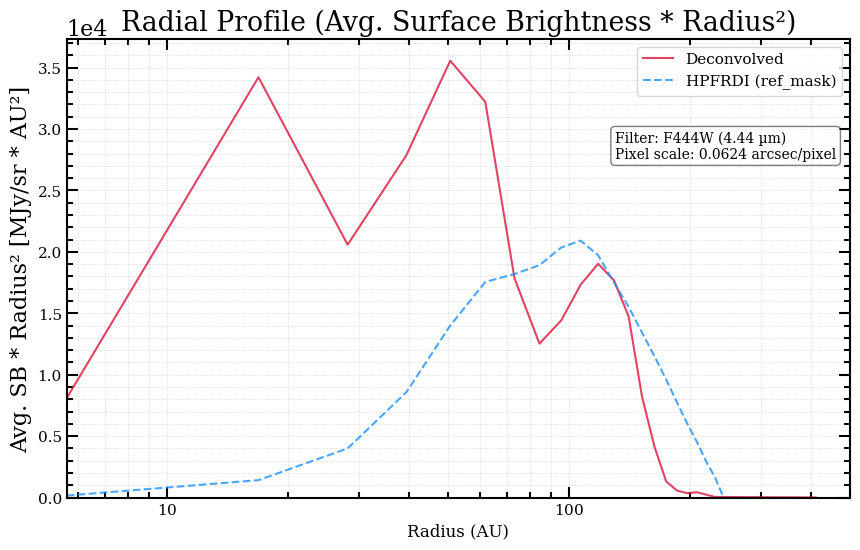

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

# Function to calculate radial profile using annular bins
def calculate_radial_profile(image_data, center_yx, max_radius_px, bin_size_px=1):
    """
    Calculates the average radial profile of an image in annular bins.

    Args:
        image_data (np.ndarray): The 2D image data.
        center_yx (tuple): The (y, x) coordinates of the center.
        max_radius_px (int): The maximum radius (in pixels) to calculate the profile up to.
        bin_size_px (int, optional): The width of each radial bin in pixels. Defaults to 1.

    Returns:
        tuple: (bin_centers_pixels, profile_values)
               - bin_centers_pixels (np.ndarray): The center radius of each bin in pixels.
               - profile_values (np.ndarray): The average value within each radial bin.
    """
    ny, nx = image_data.shape
    center_y, center_x = center_yx

    # Create coordinate grids
    y_coords, x_coords = np.ogrid[:ny, :nx]

    # Calculate squared distance from center for efficiency
    dist_sq = (x_coords - center_x)**2 + (y_coords - center_y)**2

    # Define radial bins
    radii_edges = np.arange(0, max_radius_px + bin_size_px, bin_size_px)
    profile_values = []

    # Calculate mean in each annulus
    for i in range(len(radii_edges) - 1):
        r_min_sq = radii_edges[i]**2
        r_max_sq = radii_edges[i+1]**2

        # Create mask for the current annulus
        mask_area = (dist_sq >= r_min_sq) & (dist_sq < r_max_sq)

        if np.any(mask_area): # Only calculate if mask is not empty
            avg_value = np.nanmean(image_data[mask_area])
        else:
            avg_value = np.nan # Handle empty bins

        profile_values.append(avg_value)

    # Use the center of the bins for the radius value
    bin_centers_pixels = radii_edges[:-1] + bin_size_px / 2.0
    return bin_centers_pixels, np.array(profile_values)


if __name__ == "__main__":
    # --- Input Data ---
    img_deconv = deconv_reduc[0].im
    img_hpfrdi = deconv_reduc[1].im
    labels = ['Deconvolved', 'HPFRDI (ref_mask)']
    colors = ['crimson', 'dodgerblue']
    linestyles = ['-', '--']

    # --- Determine Center and Max Radius ---
    # Assuming images are aligned and have the same shape
    if img_deconv.shape != img_hpfrdi.shape:
        print("Warning: Image shapes differ. Using shape of first image for geometry.")
    ny, nx = img_deconv.shape
    # Use integer division for center pixel index
    center_y, center_x = ny // 2, nx // 2
    # Calculate profile out towards the edge
    max_radius_px = min(ny, nx) // 2

    # --- Binning ---
    bin_size_px = 3 # Use 1-pixel wide bins for detailed profile

    # --- Calculate Profiles ---
    print(f"Calculating radial profiles with bin size {bin_size_px} px up to {max_radius_px} px...")
    radii_px_deconv, profile_deconv = calculate_radial_profile(img_deconv, (center_y, center_x), max_radius_px, bin_size_px)
    radii_px_hpfrdi, profile_hpfrdi = calculate_radial_profile(img_hpfrdi, (center_y, center_x), max_radius_px, bin_size_px)
    profiles = [profile_deconv, profile_hpfrdi]
    # Assuming radii are the same for both as images have same shape/center
    radii_px = radii_px_deconv

    # --- Unit Conversion ---
    x_label = 'Radius (pixels)' # Default label
    radii_plot = radii_px      # Default radii to plot
    try:
        if 'wdb' in locals() or 'wdb' in globals():
            pixel_scale_arcsec = wdb.pxscale.to(u.arcsec/u.pixel).value
            if 'distance' in locals() or 'distance' in globals():
                pixel_scale_au = pixel_scale_arcsec * distance
                radii_plot = radii_px * pixel_scale_au
                x_label = 'Radius (AU)'
                print(f"Converted radius to AU using scale {pixel_scale_arcsec:.4f} arcsec/px and distance {distance} pc.")
            else:
                 print("Warning: 'distance' variable not found. Cannot convert radius to AU.")
        else:
             print("Warning: 'wdb' object not found. Cannot get pixel scale to convert radius to AU.")
    except Exception as e:
        print(f"Warning: Error during unit conversion ({e}). Plotting radius in pixels.")
        radii_plot = radii_px
        x_label = 'Radius (pixels)'


    # --- Plotting ---
    print("Generating plot...")
    fig_radial, ax_radial = plt.subplots(figsize=(9, 6)) # Create a new figure

    for i in range(len(profiles)):
        # Filter out potential NaN values before plotting (especially for log scale)
        valid_mask = ~np.isnan(profiles[i]) & (profiles[i] > 0) # Also ensure positive for log scale
        if np.any(valid_mask):
             ax_radial.plot(radii_plot[valid_mask], profiles[i][valid_mask]*radii_plot[valid_mask]**2,
                           label=labels[i],
                           color=colors[i],
                           linestyle=linestyles[i],
                           markersize=4,
                           linewidth=1.5,
                           alpha=0.8)
        else:
             print(f"No valid data points found for profile: {labels[i]}")


    # --- Plot Styling ---
    ax_radial.set_xlabel(x_label, fontsize=12)
    # Clarify y-axis units if known, otherwise state they are image units
    y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
    ax_radial.set_ylabel(f'Avg. SB * Radius² [{y_units_str} * AU²]')
    ax_radial.set_title('Radial Profile (Avg. Surface Brightness * Radius²)')
    # Add a text box with filter info
    textstr = f"Filter: {info_str}\nPixel scale: {pixel_scale_value:.4f} {units}/pixel"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax_radial.text(0.7, 0.8, textstr, transform=ax_radial.transAxes,
                   fontsize=10, verticalalignment='top', bbox=props)

    # Set scales AFTER plotting data
    ax_radial.set_xscale('log') # Log scale for radius

    # Set x-axis and y-axis limits
    ax_radial.set_xlim(left=0, right=500) # Avoid zero radius
    ax_radial.set_ylim(bottom=0.0) # Avoid negative values

    # Scientific notation for y-axis
    ax_radial.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    ax_radial.legend(fontsize=11)
    ax_radial.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7) # Add grid for readability
    ax_radial.tick_params(axis='both', which='major', labelsize=11) # Adjust tick label size

    # Optional: Set reasonable plot limits if auto-scaling is poor
    # Consider excluding the very first bin if it's often noisy or affected by centering
    if len(radii_plot) > 1:
         ax_radial.set_xlim(left=radii_plot[1 if bin_size_px==1 else 0]) # Start from second bin if bin_size is 1? Or adjust as needed.

    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

Calculating radial profiles using 'log' bins...
Outlier clipping fraction: 5.0%
 -> Deconvolved: Log bins, num=100, min_r=1.0 px
 -> HPFRDI (ref_mask): Log bins, num=100, min_r=1.0 px
Converted radius to AU using scale 0.0624 arcsec/px and distance 60.1 pc.
Generating plot...


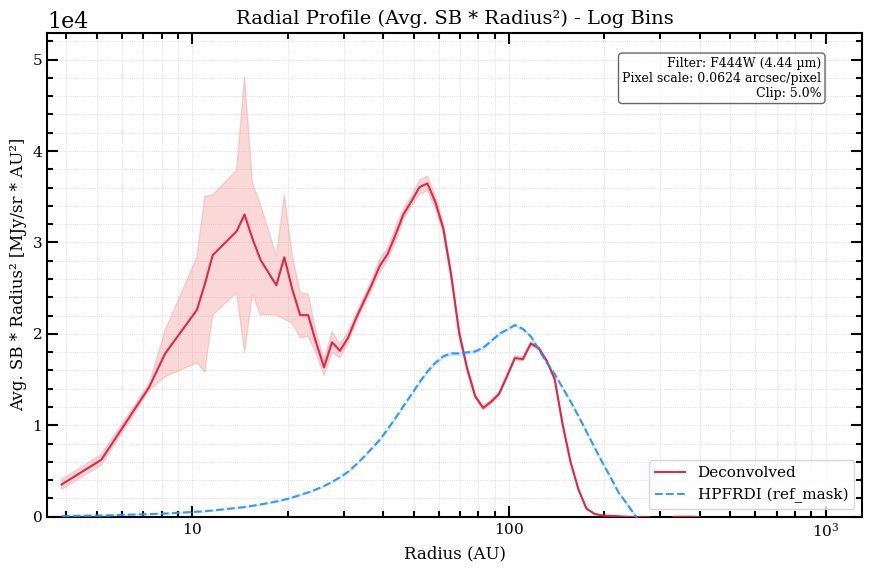

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings # To handle potential warnings from nanpercentile etc.

# Function to calculate radial profile with options
def calculate_radial_profile(
    image_data,
    center_yx,
    max_radius_px,
    bin_type='linear', # 'linear' or 'log'
    bin_param=1, # bin_size_px if linear, num_bins if log
    min_radius_px=1.0, # Only used for log bins (must be > 0)
    outlier_clip_fraction=0.0 # Fraction of total data to clip (e.g., 0.05 clips top 2.5% and bottom 2.5%)
    ):
    """
    Calculates the average radial profile of an image in annular bins,
    with options for linear/log spacing, error calculation (std dev),
    and outlier rejection.

    Args:
        image_data (np.ndarray): The 2D image data.
        center_yx (tuple): The (y, x) coordinates of the center.
        max_radius_px (int): The maximum radius (in pixels) to calculate the profile up to.
        bin_type (str, optional): Type of radial bins: 'linear' or 'log'. Defaults to 'linear'.
        bin_param (int, optional): If bin_type='linear', this is the width of each bin (bin_size_px).
                                   If bin_type='log', this is the number of bins (num_bins).
                                   Defaults to 1 (meaning 1px linear bins).
        min_radius_px (float, optional): The minimum radius (in pixels) for the bins if bin_type='log'.
                                         Must be > 0. Defaults to 1.0.
        outlier_clip_fraction (float, optional): Total fraction of data points to clip from the
                                                 tails (lowest and highest values) within each bin
                                                 before calculating mean and std dev. E.g., 0.05 removes
                                                 the lowest 2.5% and highest 2.5%. Defaults to 0.0 (no clipping).

    Returns:
        tuple: (bin_centers_pixels, profile_mean, profile_std)
            - bin_centers_pixels (np.ndarray): The center radius of each bin in pixels.
            - profile_mean (np.ndarray): The (potentially clipped) average value within each radial bin.
            - profile_std (np.ndarray): The (potentially clipped) standard deviation within each radial bin.
            Returns (None, None, None) if inputs are invalid.
    """
    ny, nx = image_data.shape
    center_y, center_x = center_yx

    # --- Input Validation and Bin Setup ---
    if bin_type == 'log':
        if min_radius_px <= 0:
            print("Error: min_radius_px must be greater than 0 for log bins.")
            return None, None, None
        if max_radius_px <= min_radius_px:
            print("Error: max_radius_px must be greater than min_radius_px for log bins.")
            return None, None, None
        num_bins = int(bin_param)
        if num_bins <= 0:
            print("Error: Number of log bins (bin_param) must be > 0.")
            return None, None, None
        # We need num_bins + 1 edges to define num_bins intervals
        radii_edges = np.logspace(np.log10(min_radius_px), np.log10(max_radius_px), num_bins + 1)
        # Geometric mean for log bin centers
        bin_centers_pixels = np.sqrt(radii_edges[:-1] * radii_edges[1:])
    elif bin_type == 'linear':
        bin_size_px = int(bin_param)
        if bin_size_px <= 0:
            print("Error: Linear bin size (bin_param) must be > 0.")
            return None, None, None
        if max_radius_px <= 0:
            print("Error: max_radius_px must be > 0 for linear bins.")
            return None, None, None
        radii_edges = np.arange(0, max_radius_px + bin_size_px, bin_size_px)
        # Ensure max_radius is included if it falls exactly on an edge transition
        if radii_edges[-1] > max_radius_px + bin_size_px / 2: # Approx check
            radii_edges = radii_edges[:-1]
        if radii_edges[-1] < max_radius_px: # Ensure last edge reaches max_radius
            radii_edges = np.append(radii_edges, max_radius_px)

        # Arithmetic mean for linear bin centers
        bin_centers_pixels = radii_edges[:-1] + (radii_edges[1:] - radii_edges[:-1]) / 2.0
    else:
        print(f"Error: Unknown bin_type '{bin_type}'. Choose 'linear' or 'log'.")
        return None, None, None

    if outlier_clip_fraction < 0 or outlier_clip_fraction >= 1:
        print("Warning: outlier_clip_fraction should be between 0 and 1. Setting to 0.")
        outlier_clip_fraction = 0.0

    # --- Calculation ---
    y_coords, x_coords = np.ogrid[:ny, :nx]
    dist_sq = (x_coords - center_x)**2 + (y_coords - center_y)**2

    profile_mean_values = []
    profile_std_values = []

    for i in range(len(radii_edges) - 1):
        r_min_sq = radii_edges[i]**2
        r_max_sq = radii_edges[i+1]**2
        mask_area = (dist_sq >= r_min_sq) & (dist_sq < r_max_sq)

        avg_value = np.nan
        std_value = np.nan

        if np.any(mask_area):
            pixels_in_annulus = image_data[mask_area]
            # Filter out NaNs before potential clipping or calculation
            valid_pixels = pixels_in_annulus[np.isfinite(pixels_in_annulus)]
            valid_pixels_count = len(valid_pixels)

            if valid_pixels_count > 0: # Proceed only if non-NaN pixels exist
                if outlier_clip_fraction > 0 and valid_pixels_count > 2: # Need >2 points to clip meaningfully
                    lower_percentile = (outlier_clip_fraction / 2.0) * 100
                    upper_percentile = (1.0 - outlier_clip_fraction / 2.0) * 100
                    try:
                        # Use nanpercentile just in case, though we filtered finite values
                        with warnings.catch_warnings(): # Suppress warnings if percentile is outside data range
                            warnings.simplefilter("ignore", category=RuntimeWarning)
                            vmin, vmax = np.percentile(valid_pixels, [lower_percentile, upper_percentile])

                        # Clip the data
                        clipped_pixels = valid_pixels[(valid_pixels >= vmin) & (valid_pixels <= vmax)]
                        clipped_pixels_count = len(clipped_pixels)

                        if clipped_pixels_count > 0:
                            avg_value = np.mean(clipped_pixels)
                            # Need at least 2 points for meaningful std dev
                            std_value = np.std(clipped_pixels)/np.sqrt(clipped_pixels_count) if clipped_pixels_count > 1 else 0.0
                        else:
                            # If clipping removed all data (unlikely but possible), revert to original mean/std
                            avg_value = np.mean(valid_pixels)
                            std_value = np.std(valid_pixels)/np.sqrt(valid_pixels_count) if valid_pixels_count > 1 else 0.0

                    except IndexError: # Handles cases where percentile calculation fails (e.g., too few points)
                        # Fallback to no clipping if percentile fails
                        avg_value = np.mean(valid_pixels)
                        std_value = np.std(valid_pixels)/np.sqrt(valid_pixels_count) if valid_pixels_count > 1 else 0.0
                else:
                    # No clipping requested or too few points
                    avg_value = np.mean(valid_pixels)
                    std_value = np.std(valid_pixels)/np.sqrt(valid_pixels_count) if valid_pixels_count > 1 else 0.0 # Std dev is 0 for 1 point

        profile_mean_values.append(avg_value)
        profile_std_values.append(std_value)

    return bin_centers_pixels, np.array(profile_mean_values), np.array(profile_std_values)


if __name__ == "__main__":
    # --- User Choices ---
    BINNING_MODE = 'log' # Options: 'linear' or 'log'
    OUTLIER_CLIP = 0.05   # Fraction to clip (e.g., 0.05 = 5% total), 0.0 to disable

    # --- Binning Parameters ---
    # Parameters for LINEAR binning
    linear_bin_size_px = 3
    # Parameters for LOG binning
    num_log_bins = 100
    min_radius_px_log = 1.0 # Smallest radius for log bins (must be > 0)

    # --- Input Data ---
    img_deconv = deconv_reduc[0].im
    img_hpfrdi = deconv_reduc[1].im
    labels = ['Deconvolved', 'HPFRDI (ref_mask)']
    colors = ['crimson', 'dodgerblue']
    linestyles = ['-', '--']
    fill_colors = ['lightcoral', 'lightskyblue'] # Colors for error bands

    # --- Determine Center and Max Radius ---
    if img_deconv.shape != img_hpfrdi.shape:
        print("Warning: Image shapes differ. Using shape of first image for geometry.")
    ny, nx = img_deconv.shape
    center_y, center_x = ny // 2, nx // 2
    max_radius_px = min(ny, nx) // 2

    # --- Calculate Profiles ---
    profiles_mean = []
    profiles_std = []
    radii_px_list = []

    print(f"Calculating radial profiles using '{BINNING_MODE}' bins...")
    print(f"Outlier clipping fraction: {OUTLIER_CLIP*100:.1f}%")

    for i, img in enumerate([img_deconv, img_hpfrdi]):
        if BINNING_MODE == 'linear':
            print(f" -> {labels[i]}: Linear bins, size={linear_bin_size_px} px")
            radii_px, profile_mean, profile_std = calculate_radial_profile(
                img, (center_y, center_x), max_radius_px,
                bin_type='linear',
                bin_param=linear_bin_size_px,
                outlier_clip_fraction=OUTLIER_CLIP
            )
        elif BINNING_MODE == 'log':
            print(f" -> {labels[i]}: Log bins, num={num_log_bins}, min_r={min_radius_px_log} px")
            radii_px, profile_mean, profile_std = calculate_radial_profile(
                img, (center_y, center_x), max_radius_px,
                bin_type='log',
                bin_param=num_log_bins,
                min_radius_px=min_radius_px_log,
                outlier_clip_fraction=OUTLIER_CLIP
            )
        else:
             raise ValueError(f"Invalid BINNING_MODE: {BINNING_MODE}")

        if radii_px is None:
            print(f"Error calculating profile for {labels[i]}. Exiting.")
            exit()

        radii_px_list.append(radii_px)
        profiles_mean.append(profile_mean)
        profiles_std.append(profile_std)

    # Assuming radii are the same for both if binning params are identical
    # If using different params per image, this needs adjustment
    radii_px = radii_px_list[0]

    # --- Unit Conversion ---
    x_label = 'Radius (pixels)' # Default label
    radii_plot = radii_px      # Default radii to plot
    pixel_scale_arcsec = None
    pixel_scale_au = None
    distance_pc = None

    try:
        if 'wdb' in locals() or 'wdb' in globals():
            pixel_scale_arcsec = wdb.pxscale.to(u.arcsec/u.pixel).value
            pixel_scale_value = pixel_scale_arcsec # For text box
            units = 'arcsec'
            if 'distance' in locals() or 'distance' in globals():
                distance_pc = distance
                pixel_scale_au = pixel_scale_arcsec * distance_pc
                radii_plot = radii_px * pixel_scale_au
                x_label = 'Radius (AU)'
                print(f"Converted radius to AU using scale {pixel_scale_arcsec:.4f} arcsec/px and distance {distance_pc} pc.")
            else:
                print("Warning: 'distance' variable not found. Cannot convert radius to AU.")
                pixel_scale_value = pixel_scale_arcsec
                units = 'arcsec'
        else:
            print("Warning: 'wdb' object not found. Cannot get pixel scale to convert radius to AU.")
            try: # Try using dummy values if previously defined
                pixel_scale_value = pixel_scale_value
                units = units
            except NameError:
                pixel_scale_value = np.nan
                units = "unknown"
    except Exception as e:
        print(f"Warning: Error during unit conversion ({e}). Plotting radius in pixels.")
        radii_plot = radii_px
        x_label = 'Radius (pixels)'
        try: # Try using dummy values if previously defined
            pixel_scale_value = pixel_scale_value
            units = units
        except NameError:
            pixel_scale_value = np.nan
            units = "unknown"


    # --- Plotting ---
    print("Generating plot...")
    fig_radial, ax_radial = plt.subplots(figsize=(9, 6))

    y_label = f'Avg. SB * Radius² [Pixel Units * Pixel²]' # Default Y label
    y_units_str = 'Pixel Units'

    for i in range(len(profiles_mean)):
        # Filter out NaNs in mean, std dev, and radii before plotting/calculation
        valid_mask = (
            np.isfinite(profiles_mean[i]) &
            np.isfinite(profiles_std[i]) &
            np.isfinite(radii_plot) &
            (radii_plot > 0) # Ensure positive for log x-scale & R^2 calc
            # Optional: Add condition for positive mean if log y-scale is intended
            # & (profiles_mean[i] > 0)
        )

        if np.any(valid_mask):
            # Apply mask
            r_plot_valid = radii_plot[valid_mask]
            mean_valid = profiles_mean[i][valid_mask]
            std_valid = profiles_std[i][valid_mask]

            # Calculate SB * R^2 and error propagation (approximate for std dev)
            sb_r_squared = mean_valid * r_plot_valid**2
            # Error prop: sigma(Y*X^2) approx= X^2 * sigma(Y) assuming X (radius) is precise
            err_sb_r_squared = std_valid * r_plot_valid**2

            # Plot the mean profile line
            ax_radial.plot(r_plot_valid, sb_r_squared,
                           label=labels[i],
                           color=colors[i],
                           linestyle=linestyles[i],
                           linewidth=1.5,
                           alpha=0.9,
                           zorder=10) # Ensure line is on top of fill

            # Plot the error band (+/- 1 sigma)
            ax_radial.fill_between(r_plot_valid,
                                   sb_r_squared - err_sb_r_squared,
                                   sb_r_squared + err_sb_r_squared,
                                   color=fill_colors[i], # Use specific fill color
                                   alpha=0.3,      # Transparency
                                   label='_nolegend_', # Don't add error band to legend
                                   zorder=5)      # Ensure fill is behind line

            # Update Y label if units are known (only needs doing once really)
            if i == 0: # Do this only once based on the first plot
                if x_label == 'Radius (AU)':
                    try:
                        y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
                        y_label = f'Avg. SB * Radius² [{y_units_str} * AU²]'
                    except Exception: # Catch potential errors broadly
                        y_label = f'Avg. SB * Radius² [Image Units * AU²]'
                elif x_label == 'Radius (pixels)':
                    try:
                        y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
                        y_label = f'Avg. SB * Radius² [{y_units_str} * Pixels²]'
                    except Exception:
                        y_label = f'Avg. SB * Radius² [Image Units * Pixels²]'

        else:
            print(f"Warning: No valid data points found for profile: {labels[i]}")


    # --- Plot Styling ---
    ax_radial.set_xlabel(x_label, fontsize=12)
    ax_radial.set_ylabel(y_label, fontsize=12)
    ax_radial.set_title(f'Radial Profile (Avg. SB * Radius²) - {BINNING_MODE.capitalize()} Bins', fontsize=14)

    # Add text box
    scale_text = f"{pixel_scale_value:.4f} {units}/pixel" if np.isfinite(pixel_scale_value) else "Unknown"
    clip_text = f"Clip: {OUTLIER_CLIP*100:.1f}%" if OUTLIER_CLIP > 0 else "Clip: None"
    textstr = f"Filter: {info_str}\nPixel scale: {scale_text}\n{clip_text}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.6)
    ax_radial.text(0.95, 0.95, textstr, transform=ax_radial.transAxes,
                   fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=props)

    # Set scales AFTER plotting
    if BINNING_MODE == 'log' or (len(radii_plot) > 0 and np.max(radii_plot) / np.min(radii_plot[radii_plot > 0]) > 50): # Heuristic for log scale
         ax_radial.set_xscale('log')
    else:
         ax_radial.set_xscale('linear')

    # Set y-axis limits
    # Find min/max across all valid error bands for setting limits
    all_y_min = []
    all_y_max = []
    for i in range(len(profiles_mean)):
        valid_mask = (
           np.isfinite(profiles_mean[i]) & np.isfinite(profiles_std[i]) & np.isfinite(radii_plot) & (radii_plot > 0)
        )
        if np.any(valid_mask):
            r_plot_valid = radii_plot[valid_mask]
            mean_valid = profiles_mean[i][valid_mask]
            std_valid = profiles_std[i][valid_mask]
            sb_r_squared = mean_valid * r_plot_valid**2
            err_sb_r_squared = std_valid * r_plot_valid**2
            all_y_min.append(np.nanmin(sb_r_squared - err_sb_r_squared))
            all_y_max.append(np.nanmax(sb_r_squared + err_sb_r_squared))

    if all_y_min and all_y_max:
        # Add some padding, ensure bottom isn't excessively negative
        plot_min_y = max(0, np.nanmin(all_y_min)) * 0.9
        plot_max_y = np.nanmax(all_y_max) * 1.1
        # Ensure min < max
        if plot_min_y < plot_max_y:
            ax_radial.set_ylim(bottom=plot_min_y, top=plot_max_y)
        else: # Fallback if something strange happened
            ax_radial.set_ylim(bottom=0) # Default safe limit
    else:
        ax_radial.set_ylim(bottom=0) # Default safe limit

    # Set x-axis limits based on the plot radii
    valid_radii = radii_plot[np.isfinite(radii_plot) & (radii_plot > 0)]
    if len(valid_radii) > 0:
        min_plot_radius = np.min(valid_radii)
        max_plot_radius = np.max(valid_radii)
        if ax_radial.get_xscale() == 'log':
            ax_radial.set_xlim(left=min_plot_radius * 0.9, right=max_plot_radius * 1.1)
        else:
            # For linear scale, often start near 0 unless min_radius_px is large
            start_radius = 0 if BINNING_MODE=='linear' else min_radius_px_log * (pixel_scale_au if pixel_scale_au else 1) * 0.9
            ax_radial.set_xlim(left=start_radius, right=max_plot_radius * 1.05)
    else:
        # Fallback limits
        fallback_min = (min_radius_px_log if BINNING_MODE=='log' else 1) * (pixel_scale_au if pixel_scale_au else 1)
        fallback_max = max_radius_px * (pixel_scale_au if pixel_scale_au else 1)
        ax_radial.set_xlim(left=fallback_min * 0.9, right=fallback_max * 1.1)


    # Scientific notation for y-axis
    ax_radial.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    ax_radial.legend(fontsize=11)
    ax_radial.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
    ax_radial.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout()
    plt.show()

Pixel scale: 0.0624 arcsec/px. Distance: 60.1 pc.
AU scale: 3.7517 AU/px.

Calculating radial profiles using 'log' bins...
Outlier clipping fraction: 5.0%
 -> Deconvolved (Sim): Log bins, num=50, min_r=1.0 px
 -> HPFRDI (Sim Ring): Log bins, num=50, min_r=1.0 px

Generating Radial Profile Plot...

Calculating Rectified Polar Profiles at radii: [20, 50, 80] px...
 -> Deconvolved (Sim) @ 20 px
 -> HPFRDI (Sim Ring) @ 20 px
 -> Deconvolved (Sim) @ 50 px
 -> HPFRDI (Sim Ring) @ 50 px
 -> Deconvolved (Sim) @ 80 px
 -> HPFRDI (Sim Ring) @ 80 px


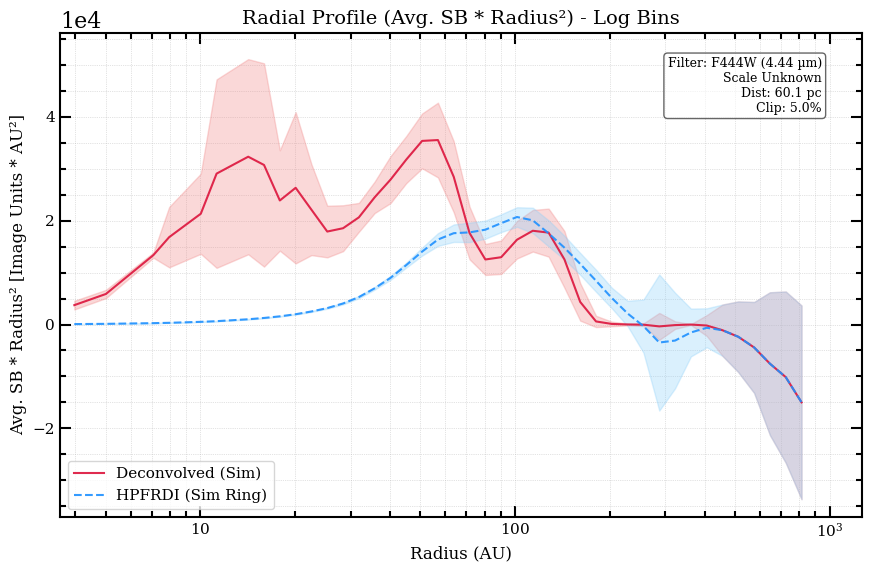

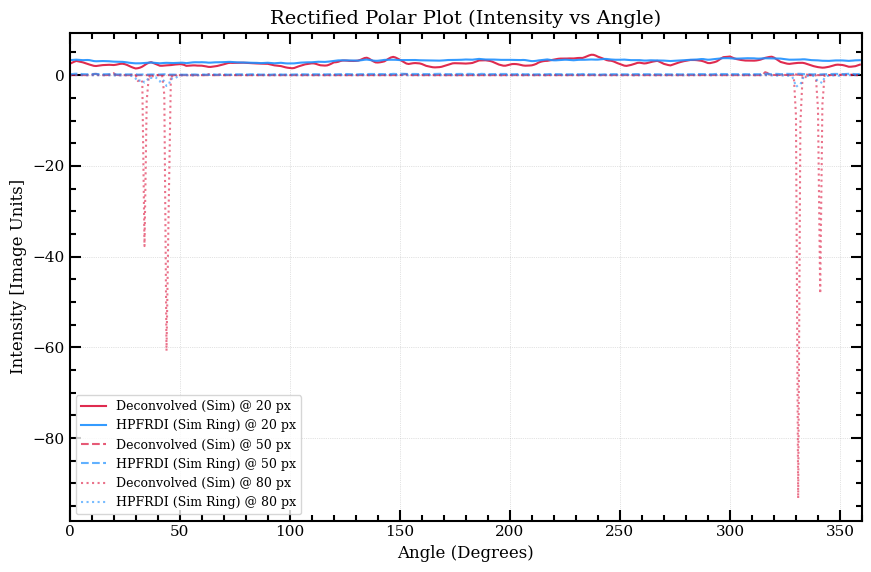

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings # To handle potential warnings from nanpercentile etc.
# Ensure scipy is installed: pip install scipy
from scipy.ndimage import map_coordinates # For interpolation

# Function to calculate radial profile with options
def calculate_radial_profile(
    image_data,
    center_yx,
    max_radius_px,
    bin_type='linear', # 'linear' or 'log'
    bin_param=1, # bin_size_px if linear, num_bins if log
    min_radius_px=1.0, # Only used for log bins (must be > 0)
    outlier_clip_fraction=0.0 # Fraction of total data to clip (e.g., 0.05 clips top 2.5% and bottom 2.5%)
    ):
    """
    Calculates the average radial profile of an image in annular bins,
    with options for linear/log spacing, error calculation (std dev),
    and outlier rejection.

    (Docstring remains the same as provided)
    """
    ny, nx = image_data.shape
    center_y, center_x = center_yx

    # --- Input Validation and Bin Setup ---
    if bin_type == 'log':
        if min_radius_px <= 0:
            print("Error: min_radius_px must be greater than 0 for log bins.")
            return None, None, None
        if max_radius_px <= min_radius_px:
            print("Error: max_radius_px must be greater than min_radius_px for log bins.")
            return None, None, None
        num_bins = int(bin_param)
        if num_bins <= 0:
            print("Error: Number of log bins (bin_param) must be > 0.")
            return None, None, None
        # We need num_bins + 1 edges to define num_bins intervals
        radii_edges = np.logspace(np.log10(min_radius_px), np.log10(max_radius_px), num_bins + 1)
        # Geometric mean for log bin centers
        bin_centers_pixels = np.sqrt(radii_edges[:-1] * radii_edges[1:])
    elif bin_type == 'linear':
        bin_size_px = int(bin_param)
        if bin_size_px <= 0:
            print("Error: Linear bin size (bin_param) must be > 0.")
            return None, None, None
        if max_radius_px <= 0:
            print("Error: max_radius_px must be > 0 for linear bins.")
            return None, None, None
        radii_edges = np.arange(0, max_radius_px + bin_size_px, bin_size_px)
        # Ensure max_radius is included if it falls exactly on an edge transition
        if radii_edges[-1] > max_radius_px + bin_size_px / 2: # Approx check
            radii_edges = radii_edges[:-1]
        if radii_edges[-1] < max_radius_px: # Ensure last edge reaches max_radius
            radii_edges = np.append(radii_edges, max_radius_px)

        # Arithmetic mean for linear bin centers
        bin_centers_pixels = radii_edges[:-1] + (radii_edges[1:] - radii_edges[:-1]) / 2.0
    else:
        print(f"Error: Unknown bin_type '{bin_type}'. Choose 'linear' or 'log'.")
        return None, None, None

    if outlier_clip_fraction < 0 or outlier_clip_fraction >= 1:
        print("Warning: outlier_clip_fraction should be between 0 and 1. Setting to 0.")
        outlier_clip_fraction = 0.0

    # --- Calculation ---
    y_coords, x_coords = np.ogrid[:ny, :nx]
    dist_sq = (x_coords - center_x)**2 + (y_coords - center_y)**2

    profile_mean_values = []
    profile_std_values = []

    for i in range(len(radii_edges) - 1):
        r_min_sq = radii_edges[i]**2
        r_max_sq = radii_edges[i+1]**2
        mask_area = (dist_sq >= r_min_sq) & (dist_sq < r_max_sq)

        avg_value = np.nan
        std_value = np.nan

        if np.any(mask_area):
            pixels_in_annulus = image_data[mask_area]
            # Filter out NaNs before potential clipping or calculation
            valid_pixels = pixels_in_annulus[np.isfinite(pixels_in_annulus)]

            if len(valid_pixels) > 0: # Proceed only if non-NaN pixels exist
                if outlier_clip_fraction > 0 and len(valid_pixels) > 2: # Need >2 points to clip meaningfully
                    lower_percentile = (outlier_clip_fraction / 2.0) * 100
                    upper_percentile = (1.0 - outlier_clip_fraction / 2.0) * 100
                    try:
                        # Use nanpercentile just in case, though we filtered finite values
                        with warnings.catch_warnings(): # Suppress warnings if percentile is outside data range
                            warnings.simplefilter("ignore", category=RuntimeWarning)
                            # Use percentile on valid_pixels which has no NaNs
                            vmin, vmax = np.percentile(valid_pixels, [lower_percentile, upper_percentile])

                        # Clip the data
                        clipped_pixels = valid_pixels[(valid_pixels >= vmin) & (valid_pixels <= vmax)]

                        if len(clipped_pixels) > 0:
                            avg_value = np.mean(clipped_pixels)
                            # Need at least 2 points for meaningful std dev
                            std_value = np.std(clipped_pixels) if len(clipped_pixels) > 1 else 0.0
                        else:
                            # If clipping removed all data (unlikely but possible), revert to original mean/std
                            avg_value = np.mean(valid_pixels)
                            std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0

                    except IndexError: # Handles cases where percentile calculation fails (e.g., too few points)
                        # Fallback to no clipping if percentile fails
                        avg_value = np.mean(valid_pixels)
                        std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0
                else:
                    # No clipping requested or too few points
                    avg_value = np.mean(valid_pixels)
                    std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0 # Std dev is 0 for 1 point

        profile_mean_values.append(avg_value)
        profile_std_values.append(std_value)

    return bin_centers_pixels, np.array(profile_mean_values), np.array(profile_std_values)


# Function to extract rectified polar profile
def rectified_polar_profile(image_data, center_yx, radius_px, num_angles=360, interpolation_order=1):
    """
    Extracts image intensity along a circle at a specific radius using interpolation.

    Args:
        image_data (np.ndarray): The 2D image data.
        center_yx (tuple): The (y, x) coordinates of the center.
        radius_px (float): The radius (in pixels) at which to extract the profile.
        num_angles (int, optional): Number of points to sample around the circle. Defaults to 360.
        interpolation_order (int, optional): Order of spline interpolation (e.g., 0=nearest, 1=bilinear, 3=cubic).
                                            Defaults to 1.

    Returns:
        tuple: (angles_deg, intensity_profile)
            - angles_deg (np.ndarray): Angles in degrees (0 to 360).
            - intensity_profile (np.ndarray): Interpolated intensity values at each angle.
                                              Returns (None, None) if radius is non-positive.
    """
    if radius_px <= 0:
        print(f"Warning: Radius must be positive. Got {radius_px}. Skipping.")
        return None, None

    ny, nx = image_data.shape
    center_y, center_x = center_yx

    # Generate angles
    # Use endpoint=False to avoid duplicating 0 and 360 degrees
    theta_rad = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)
    angles_deg = np.rad2deg(theta_rad)

    # Calculate coordinates along the circle
    # Remember image indexing is [y, x]
    y_coords = center_y + radius_px * np.sin(theta_rad)
    x_coords = center_x + radius_px * np.cos(theta_rad)

    # Stack coordinates in the format required by map_coordinates: [[y1, y2,...], [x1, x2,...]]
    coords = np.vstack((y_coords, x_coords))

    # Interpolate image values at the coordinates
    # mode='nearest' handles points outside the image boundary by taking the nearest pixel value
    # cval=np.nan could be used if you want NaNs for points outside, but 'nearest' might be safer
    intensity_profile = map_coordinates(image_data, coords, order=interpolation_order, mode='nearest')

    return angles_deg, intensity_profile


# --- Main Execution Block ---
if __name__ == "__main__":

    # --- User Choices ---
    BINNING_MODE = 'log' # Options: 'linear' or 'log'
    OUTLIER_CLIP = 0.05   # Fraction to clip (e.g., 0.05 = 5% total), 0.0 to disable

    # --- Binning Parameters ---
    linear_bin_size_px = 3
    num_log_bins = 50 # Reduced for faster dummy run
    min_radius_px_log = 1.0

    # --- Radii for Rectified Polar Plot ---
    radii_to_plot_px = [20, 50, 80] # Choose radii (in pixels) you are interested in
    num_angles_polar = 360 # Resolution for the polar plot
    interp_order_polar = 1 # Interpolation order (1=bilinear)

    # --- Input Data ---
    # Using dummy data created above
    labels = ['Deconvolved (Sim)', 'HPFRDI (Sim Ring)']
    colors = ['crimson', 'dodgerblue']
    linestyles = ['-', '--']
    fill_colors = ['lightcoral', 'lightskyblue'] # Colors for error bands

    # --- Determine Center and Max Radius ---
    if img_deconv.shape != img_hpfrdi.shape:
        print("Warning: Image shapes differ. Using shape of first image for geometry.")
    ny, nx = img_deconv.shape
    center_y, center_x = ny // 2, nx // 2
    max_radius_px = min(ny, nx) // 2

    # --- Unit Conversion Setup (Handles potential missing info) ---
    pixel_scale_arcsec = None
    pixel_scale_au = None
    distance_pc = None
    pixel_scale_value = np.nan
    units = "unknown"
    y_units_str = 'Image Units' # Default

    try:
        if wdb is not None:
            pixel_scale_arcsec = wdb.pxscale.to(u.arcsec/u.pixel).value
            pixel_scale_value = pixel_scale_arcsec
            units = 'arcsec'
            if distance is not None:
                distance_pc = distance
                pixel_scale_au = pixel_scale_arcsec * distance_pc
                print(f"Pixel scale: {pixel_scale_arcsec:.4f} arcsec/px. Distance: {distance_pc} pc.")
                print(f"AU scale: {pixel_scale_au:.4f} AU/px.")
            else:
                print(f"Pixel scale: {pixel_scale_arcsec:.4f} arcsec/px. 'distance' not available for AU conversion.")
        else:
            print("Warning: 'wdb' object not found. Cannot get pixel scale.")

        # Try getting image units
        if wdb is not None and wdb.database and wdb.concat in wdb.database.obs and 'BUNIT' in wdb.database.obs[wdb.concat]:
             y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
        else:
             y_units_str = 'Image Units' # Fallback
    except Exception as e:
        print(f"Warning: Error during unit setup ({e}). Using defaults.")
        pixel_scale_value = np.nan
        units = "unknown"
        y_units_str = 'Image Units'

    # --- 1. Calculate Radial Profiles (Existing Logic) ---
    profiles_mean = []
    profiles_std = []
    radii_px_list = []

    print(f"\nCalculating radial profiles using '{BINNING_MODE}' bins...")
    print(f"Outlier clipping fraction: {OUTLIER_CLIP*100:.1f}%")

    image_list = [img_deconv, img_hpfrdi] # Define the list here

    for i, img in enumerate(image_list):
        if BINNING_MODE == 'linear':
            print(f" -> {labels[i]}: Linear bins, size={linear_bin_size_px} px")
            radii_px, profile_mean, profile_std = calculate_radial_profile(
                img, (center_y, center_x), max_radius_px,
                bin_type='linear',
                bin_param=linear_bin_size_px,
                outlier_clip_fraction=OUTLIER_CLIP
            )
        elif BINNING_MODE == 'log':
            print(f" -> {labels[i]}: Log bins, num={num_log_bins}, min_r={min_radius_px_log} px")
            radii_px, profile_mean, profile_std = calculate_radial_profile(
                img, (center_y, center_x), max_radius_px,
                bin_type='log',
                bin_param=num_log_bins,
                min_radius_px=min_radius_px_log,
                outlier_clip_fraction=OUTLIER_CLIP
            )
        else:
             raise ValueError(f"Invalid BINNING_MODE: {BINNING_MODE}")

        if radii_px is None:
            print(f"Error calculating profile for {labels[i]}. Skipping this image for radial plot.")
            # Add placeholders to keep list lengths consistent
            radii_px_list.append(None)
            profiles_mean.append(None)
            profiles_std.append(None)
            continue # Skip to next image

        radii_px_list.append(radii_px)
        profiles_mean.append(profile_mean)
        profiles_std.append(profile_std)

    # --- Plotting Radial Profile (Existing Logic, adapted slightly) ---
    print("\nGenerating Radial Profile Plot...")
    fig_radial, ax_radial = plt.subplots(figsize=(9, 6))

    # Determine radii for plotting (AU or pixels) and labels
    radii_plot = None
    x_label = 'Radius (pixels)'
    if pixel_scale_au is not None:
        # Use the radii from the first *successful* calculation
        first_valid_idx = next((idx for idx, r in enumerate(radii_px_list) if r is not None), None)
        if first_valid_idx is not None:
            radii_plot = radii_px_list[first_valid_idx] * pixel_scale_au
            x_label = 'Radius (AU)'
            y_label_radial = f'Avg. SB * Radius² [{y_units_str} * AU²]'
        else:
            print("Warning: No valid radial profiles calculated. Cannot determine plot units.")
            radii_plot = radii_px_list[0] # Fallback, likely None
            y_label_radial = f'Avg. SB * Radius² [{y_units_str} * Pixels²]' # Fallback label
    elif pixel_scale_arcsec is not None:
        first_valid_idx = next((idx for idx, r in enumerate(radii_px_list) if r is not None), None)
        if first_valid_idx is not None:
             radii_plot = radii_px_list[first_valid_idx] * pixel_scale_arcsec
             x_label = 'Radius (arcsec)'
             y_label_radial = f'Avg. SB * Radius² [{y_units_str} * arcsec²]'
        else:
            print("Warning: No valid radial profiles calculated. Cannot determine plot units.")
            radii_plot = radii_px_list[0] # Fallback
            y_label_radial = f'Avg. SB * Radius² [{y_units_str} * Pixels²]' # Fallback label
    else:
        first_valid_idx = next((idx for idx, r in enumerate(radii_px_list) if r is not None), None)
        if first_valid_idx is not None:
            radii_plot = radii_px_list[first_valid_idx] # Use pixels
            x_label = 'Radius (pixels)'
            y_label_radial = f'Avg. SB * Radius² [{y_units_str} * Pixels²]'
        else: # Complete failure case
             print("ERROR: Cannot generate radial plot - no valid profiles calculated.")
             radii_plot = None # Ensure it's None if no valid data
             y_label_radial = 'Avg. SB * Radius²'


    # Check if we can proceed with plotting
    can_plot_radial = radii_plot is not None

    if can_plot_radial:
        all_y_min = []
        all_y_max = []
        for i in range(len(profiles_mean)):
            # Check if this profile was calculated successfully
            if profiles_mean[i] is None or radii_px_list[i] is None:
                 continue

            # Determine the correct x-axis values for *this* specific profile
            if pixel_scale_au is not None:
                current_radii_plot = radii_px_list[i] * pixel_scale_au
            elif pixel_scale_arcsec is not None:
                current_radii_plot = radii_px_list[i] * pixel_scale_arcsec
            else:
                current_radii_plot = radii_px_list[i] # pixels

            # Filter out NaNs in mean, std dev, and radii before plotting/calculation
            valid_mask = (
                np.isfinite(profiles_mean[i]) &
                np.isfinite(profiles_std[i]) &
                np.isfinite(current_radii_plot) &
                (current_radii_plot > 0) # Ensure positive for log x-scale & R^2 calc
            )

            if np.any(valid_mask):
                # Apply mask
                r_plot_valid = current_radii_plot[valid_mask]
                mean_valid = profiles_mean[i][valid_mask]
                std_valid = profiles_std[i][valid_mask]

                # Calculate SB * R^2 and error propagation
                sb_r_squared = mean_valid * r_plot_valid**2
                err_sb_r_squared = std_valid * r_plot_valid**2

                # Plot the mean profile line
                ax_radial.plot(r_plot_valid, sb_r_squared,
                               label=labels[i],
                               color=colors[i],
                               linestyle=linestyles[i],
                               linewidth=1.5,
                               alpha=0.9,
                               zorder=10) # Ensure line is on top of fill

                # Plot the error band (+/- 1 sigma)
                ax_radial.fill_between(r_plot_valid,
                                       sb_r_squared - err_sb_r_squared,
                                       sb_r_squared + err_sb_r_squared,
                                       color=fill_colors[i], # Use specific fill color
                                       alpha=0.3,      # Transparency
                                       label='_nolegend_', # Don't add error band to legend
                                       zorder=5)      # Ensure fill is behind line

                # Collect min/max for y-axis limits
                all_y_min.append(np.nanmin(sb_r_squared - err_sb_r_squared))
                all_y_max.append(np.nanmax(sb_r_squared + err_sb_r_squared))

            else:
                print(f"Warning: No valid data points found for radial profile: {labels[i]}")

        # --- Plot Styling (Radial) ---
        ax_radial.set_xlabel(x_label, fontsize=12)
        ax_radial.set_ylabel(y_label_radial, fontsize=12)
        ax_radial.set_title(f'Radial Profile (Avg. SB * Radius²) - {BINNING_MODE.capitalize()} Bins', fontsize=14)

        # Add text box
        scale_text = f"{pixel_scale_value:.4f} {units}/pixel" if np.isfinite(pixel_scale_value) else "Scale Unknown"
        clip_text = f"Clip: {OUTLIER_CLIP*100:.1f}%" if OUTLIER_CLIP > 0 else "Clip: None"
        dist_text = f"Dist: {distance_pc} pc" if distance_pc else "Dist: Unknown"
        textstr = f"Filter: {info_str}\n{scale_text}\n{dist_text}\n{clip_text}"
        props = dict(boxstyle='round', facecolor='white', alpha=0.6)
        ax_radial.text(0.95, 0.95, textstr, transform=ax_radial.transAxes,
                       fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=props)

        # Set scales AFTER plotting
        valid_radii_for_scale = radii_plot[np.isfinite(radii_plot) & (radii_plot > 0)] if radii_plot is not None else np.array([])
        if len(valid_radii_for_scale) > 1 and (BINNING_MODE == 'log' or np.max(valid_radii_for_scale) / np.min(valid_radii_for_scale) > 50):
             ax_radial.set_xscale('log')
        else:
             ax_radial.set_xscale('linear')

        # Set y-axis limits
        if all_y_min and all_y_max:
            plot_min_y = max(0, np.nanmin(all_y_min)) * 0.9 if np.nanmin(all_y_min) > 0 else np.nanmin(all_y_min) * 1.1
            plot_max_y = np.nanmax(all_y_max) * 1.1
            if not np.isnan(plot_min_y) and not np.isnan(plot_max_y) and plot_min_y < plot_max_y:
                 ax_radial.set_ylim(bottom=plot_min_y, top=plot_max_y)
            else:
                 ax_radial.autoscale(axis='y') # Fallback to auto-scaling
        else:
             ax_radial.autoscale(axis='y') # Fallback

        # Set x-axis limits based on the plot radii
        if len(valid_radii_for_scale) > 0:
            min_plot_radius = np.min(valid_radii_for_scale)
            max_plot_radius = np.max(valid_radii_for_scale)
            if ax_radial.get_xscale() == 'log':
                ax_radial.set_xlim(left=min_plot_radius * 0.9, right=max_plot_radius * 1.1)
            else:
                start_radius = 0
                if x_label == 'Radius (AU)' and min_radius_px_log > 0 and pixel_scale_au:
                    start_radius = min_radius_px_log * pixel_scale_au * 0.9 if BINNING_MODE == 'log' else 0
                elif x_label == 'Radius (arcsec)' and min_radius_px_log > 0 and pixel_scale_arcsec:
                    start_radius = min_radius_px_log * pixel_scale_arcsec * 0.9 if BINNING_MODE == 'log' else 0
                elif x_label == 'Radius (pixels)':
                     start_radius = min_radius_px_log * 0.9 if BINNING_MODE == 'log' else 0
                ax_radial.set_xlim(left=start_radius, right=max_plot_radius * 1.05)
        else:
            # Fallback limits if no valid radii found (less likely now but safe)
            ax_radial.autoscale(axis='x')

        # Scientific notation for y-axis
        ax_radial.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        ax_radial.legend(fontsize=11)
        ax_radial.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
        ax_radial.tick_params(axis='both', which='major', labelsize=11)

        plt.tight_layout()
        # plt.show() # Show radial plot immediately, or wait until after polar plot

    else:
        print("Skipping radial profile plot generation due to lack of valid data.")


    # --- 2. Calculate and Plot Rectified Polar Profiles ---
    print(f"\nCalculating Rectified Polar Profiles at radii: {radii_to_plot_px} px...")

    # Use a different set of linestyles or colors for different radii if needed
    # Here, we'll use the same color for the image source, but vary linestyle/alpha per radius
    polar_linestyles = ['-', '--', ':', '-.'] # Add more if plotting many radii
    polar_alphas = [0.9, 0.7, 0.6, 0.5]     # Vary transparency

    fig_polar, ax_polar = plt.subplots(figsize=(9, 6))
    plot_successful = False

    for idx_r, radius_val_px in enumerate(radii_to_plot_px):
        # Check if radius is valid within image bounds (approximate)
        if radius_val_px >= max_radius_px:
             print(f"Skipping radius {radius_val_px} px - exceeds max radius {max_radius_px} px.")
             continue
        if radius_val_px <= 0:
             print(f"Skipping radius {radius_val_px} px - must be positive.")
             continue

        # Cycle through linestyles and alphas based on radius index
        current_linestyle = polar_linestyles[idx_r % len(polar_linestyles)]
        current_alpha = polar_alphas[idx_r % len(polar_alphas)]

        for i, img in enumerate(image_list):
            print(f" -> {labels[i]} @ {radius_val_px} px")
            angles_deg, intensity_profile = rectified_polar_profile(
                img,
                (center_y, center_x),
                radius_val_px,
                num_angles=num_angles_polar,
                interpolation_order=interp_order_polar
            )

            if angles_deg is not None and intensity_profile is not None:
                # Generate label including radius
                plot_label = f"{labels[i]} @ {radius_val_px} px"
                # Plot intensity vs angle
                ax_polar.plot(angles_deg, intensity_profile,
                              label=plot_label,
                              color=colors[i], # Color by image source
                              linestyle=current_linestyle, # Style by radius
                              linewidth=1.5,
                              alpha=current_alpha) # Alpha by radius
                plot_successful = True # Mark that at least one plot was made
            else:
                print(f"   -> Failed to calculate polar profile.")


    # --- Plot Styling (Polar) ---
    if plot_successful:
        ax_polar.set_xlabel("Angle (Degrees)", fontsize=12)
        ax_polar.set_ylabel(f"Intensity [{y_units_str}]", fontsize=12)
        ax_polar.set_title(f'Rectified Polar Plot (Intensity vs Angle)', fontsize=14)
        ax_polar.set_xlim(0, 360) # Angles from 0 to 360 degrees
        ax_polar.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
        ax_polar.legend(fontsize=9) # Smaller font potentially for more labels
        ax_polar.tick_params(axis='both', which='major', labelsize=11)
        # Optional: Add scientific notation if values are very large/small
        # ax_polar.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        plt.tight_layout()
    else:
        print("Skipping polar plot generation - no valid profiles calculated.")
        plt.close(fig_polar) # Close the empty figure

    # --- Show all generated plots ---
    plt.show()

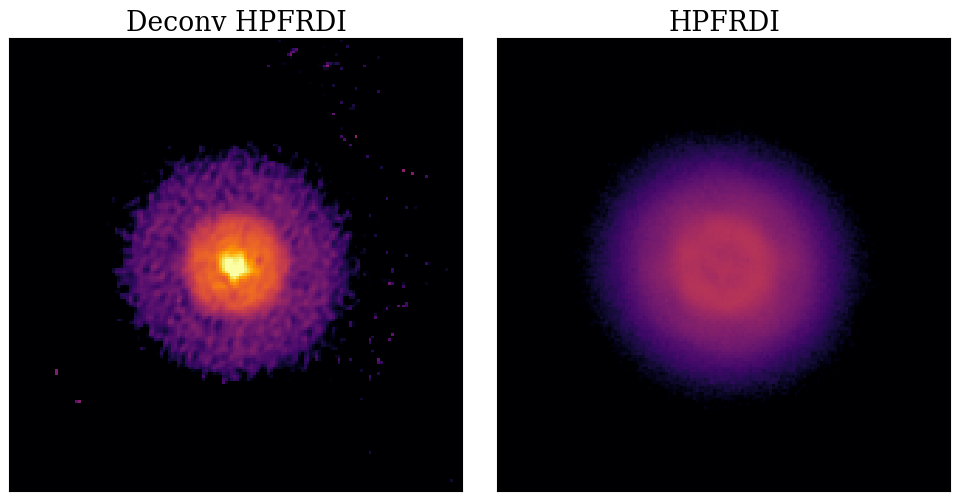

In [18]:
clim = np.array([0.001, 1])*np.nanpercentile(deconv_reduc[0].im, 99.975)
# Visualization and analysis from Task5
fig,axes = quick_implot([deconv_reduc[0].im, deconv_reduc[1].im], extent=deconv_reduc[1].extent, lims=[-5,5], clim=clim, cmap='inferno', norm=mpl.colors.LogNorm,
             interpolation='None', norm_kwargs=dict(clip=True), show=False)

for i,ax in enumerate(axes):
    ax.set_title(deconv_reduc[i].reduc_label.replace(' (Winnie)', ''))

In [ ]:
'''
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings
import emcee # MCMC sampler
import corner # Corner plots for MCMC results
from tqdm import tqdm # Progress bar
import multiprocessing
from multiprocessing import Pool

# --- MCMC Fitting Functions ---

def calculate_elliptical_radius_sq(coords_yx, center_yx, inc_rad, pa_rad):
    """
    Calculates the squared 'elliptical radius' for each pixel.
    Points on the same ellipse defined by center, inc, pa will have the same
    elliptical radius, which corresponds to the semi-major axis length.

    Args:
        coords_yx (tuple): Tuple of (y_coords, x_coords) numpy arrays.
        center_yx (tuple): (y0, x0) center coordinates.
        inc_rad (float): Inclination in radians (0=face-on, pi/2=edge-on).
        pa_rad (float): Position angle in radians (counter-clockwise from +x axis).

    Returns:
        np.ndarray: Array of squared elliptical radii for each pixel.
                    Returns None if inc_rad is invalid.
    """
    y_coords, x_coords = coords_yx
    center_y, center_x = center_yx

    # Shift coordinates to be relative to the center
    dy = y_coords - center_y
    dx = x_coords - center_x

    # Rotate coordinates by -pa (clockwise rotation aligns ellipse major axis with x')
    cos_pa = np.cos(-pa_rad)
    sin_pa = np.sin(-pa_rad)
    x_rot = dx * cos_pa - dy * sin_pa
    y_rot = dx * sin_pa + dy * cos_pa

    # Deproject y' coordinate based on inclination
    cos_inc = np.cos(inc_rad)
    if cos_inc <= 1e-6: # Avoid division by zero for edge-on
         # Handle edge-on case: points far from the major axis get large radius_sq
         # This definition might need refinement depending on exact goal for edge-on.
         # Assigning infinity or a very large number might be better if edge-on is unlikely.
         # For now, let's return None to signal an issue in likelihood.
         # print("Warning: Near edge-on inclination encountered.")
         return None # Indicate invalid parameters for likelihood

    y_deproj = y_rot / cos_inc

    # Calculate squared elliptical radius (semi-major axis squared)
    # r_ell^2 = x_rot^2 + (y_rot / cos_inc)^2
    radius_sq = x_rot**2 + y_deproj**2
    return radius_sq

def log_likelihood(theta, image_data, coords_yx, annuli_edges_r_sq):
    """
    Calculates the log likelihood for ellipse parameters.
    We define likelihood as inversely proportional to the variance within annuli.
    Maximize: -sum(variance_in_annulus) which minimizes variance.

    Args:
        theta (list/array): Parameters [x0, y0, inc_deg, pa_deg].
        image_data (np.ndarray): The 2D image data.
        coords_yx (tuple): Pre-calculated coordinate grids (y_coords, x_coords).
        annuli_edges_r_sq (np.ndarray): Array of squared semi-major axis defining annulus edges.

    Returns:
        float: Log likelihood value. Returns -np.inf if parameters are invalid
               or no valid pixels are found in annuli.
    """
    x0, y0, inc_deg, pa_deg = theta
    inc_rad = np.radians(inc_deg)
    pa_rad = np.radians(pa_deg)

    # Calculate squared elliptical radius for all pixels
    dist_sq_ell = calculate_elliptical_radius_sq(coords_yx, (y0, x0), inc_rad, pa_rad)

    if dist_sq_ell is None: # Handle invalid inclination from helper func
        return -np.inf

    total_variance = 0
    valid_annuli_count = 0

    # Calculate variance in each elliptical annulus
    for i in range(len(annuli_edges_r_sq) - 1):
        r_min_sq = annuli_edges_r_sq[i]
        r_max_sq = annuli_edges_r_sq[i+1]
        mask_area = (dist_sq_ell >= r_min_sq) & (dist_sq_ell < r_max_sq)

        if np.any(mask_area):
            pixels_in_annulus = image_data[mask_area]
            valid_pixels = pixels_in_annulus[np.isfinite(pixels_in_annulus)]

            # Need at least 2 points for variance
            if len(valid_pixels) >= 2:
                 # Using variance instead of std dev to avoid sqrt(0) issues
                 # and give more weight to reducing larger variances.
                 variance = np.var(valid_pixels)
                 # Check for zero variance (possible with discrete data/few points)
                 # Add a small floor? Or just proceed? Let's proceed for now.
                 # if variance < 1e-15: variance = 1e-15 # Avoid log(0) if using log(var)
                 total_variance += variance
                 valid_annuli_count += 1
            # Optional: Penalize if only 1 pixel is found?
            # elif len(valid_pixels) == 1:
            #     total_variance += some_penalty # Or just ignore

    if valid_annuli_count == 0:
        return -np.inf # No data found in any annulus for these parameters

    # Maximize likelihood = Minimize average variance
    # Use negative average variance as log likelihood metric
    # (Simpler than formal Gaussian likelihood, focuses on minimizing spread)
    log_like = - (total_variance / valid_annuli_count)

    # Check for NaN/inf result before returning
    if not np.isfinite(log_like):
        return -np.inf

    return log_like


def log_prior(theta, center_yx_guess, center_yx_delta, ny, nx):
    """
    Defines priors for the parameters [x0, y0, inc_deg, pa_deg].

    Args:
        theta (list/array): Parameters [x0, y0, inc_deg, pa_deg].
        center_yx_guess (tuple): Initial guess for center (y, x).
        center_yx_delta (float): Allowed deviation for center from guess (pixels).
        ny, nx (int): Image dimensions.

    Returns:
        float: 0.0 if parameters are within priors, -np.inf otherwise.
    """
    x0, y0, inc_deg, pa_deg = theta
    y_guess, x_guess = center_yx_guess

    # Prior on Center: Uniform within a box around the guess
    # Ensure center stays roughly within image bounds too
    if not (x_guess - center_yx_delta < x0 < x_guess + center_yx_delta and 0 < x0 < nx -1):
        return -np.inf
    if not (y_guess - center_yx_delta < y0 < y_guess + center_yx_delta and 0 < y0 < ny -1):
        return -np.inf

    # Prior on Inclination: Uniform between 0 and 90 degrees
    if not (0.0 <= inc_deg <= 10.0):
        return -np.inf

    # Prior on Position Angle: Uniform between 0 and 180 degrees (or -90 to 90)
    # Ellipse is symmetric after 180 deg rotation
    if not (90.0 <= pa_deg < 270.0):
        return -np.inf

    # If all checks pass:
    return 0.0

def log_probability(theta, image_data, coords_yx, annuli_edges_r_sq, center_yx_guess, center_yx_delta, ny, nx):
    """
    Combines log prior and log likelihood. This is what emcee samples.
    """
    lp = log_prior(theta, center_yx_guess, center_yx_delta, ny, nx)
    if not np.isfinite(lp):
        return -np.inf # Prior rejected

    ll = log_likelihood(theta, image_data, coords_yx, annuli_edges_r_sq)
    # Check if likelihood is finite separately
    if not np.isfinite(ll):
        return -np.inf # Likelihood invalid (e.g., bad params, no data)

    return lp + ll


# --- Main Execution ---
if __name__ == "__main__":

    # --- User Choices ---
    
    FIT_ELLIPSE = True         # Set to True to run MCMC fitting
    IMAGE_TO_FIT = img_deconv  # Choose which image to use for fitting (e.g., higher S/N)
    IMAGE_FIT_LABEL = labels[0] # Label for the image used in fitting

    # --- MCMC Parameters ---
    # Define prior ranges and initial guesses
    ny_fit, nx_fit = IMAGE_TO_FIT.shape
    center_y_guess, center_x_guess = ny_fit // 2, nx_fit // 2
    center_delta_prior = 0.5 # Allow center to vary by +/- 0.5 pixels from guess
    inc_guess = 5.0          # Initial guess for inclination (degrees)
    pa_guess = 150.0           # Initial guess for PA (degrees)

    # Elliptical annuli for likelihood calculation (use squared radii)
    # Choose a range relevant to the disk structure, avoiding the very center/edges maybe
    fit_min_r_ell_px = 5
    fit_max_r_ell_px = min(ny_fit, nx_fit) // 3 # Go out to 1/3rd of image size
    num_fit_annuli = 20
    # Use linear or log spacing for the annuli edges (in radius, then square)
    # Log spacing might be better if contrast changes rapidly near center
    fit_annuli_r_edges = np.logspace(np.log10(fit_min_r_ell_px),
                                     np.log10(fit_max_r_ell_px),
                                     num_fit_annuli + 1)
    fit_annuli_r_sq_edges = fit_annuli_r_edges**2

    # MCMC settings
    nwalkers = 64   # Number of MCMC walkers (should be > 2 * ndim)
    ndim = 4        # Number of parameters (x0, y0, inc_deg, pa_deg)
    nsteps = 100000   # Total MCMC steps per walker
    nburn = 3000     # "Burn-in" steps to discard

    # --- Pre-calculate coordinate grids ---
    y_coords_fit, x_coords_fit = np.ogrid[:ny_fit, :nx_fit]
    coords_yx_fit = (y_coords_fit, x_coords_fit)

    # --- Run MCMC Fitting (if enabled) ---
    best_fit_params = None
    flat_samples = None
    if FIT_ELLIPSE:
        print(f"Starting MCMC fitting for ellipse parameters on '{IMAGE_FIT_LABEL}'...")
        print(f"Using {num_fit_annuli} elliptical annuli from R={fit_min_r_ell_px} to {fit_max_r_ell_px} px.")
        print(f"Priors: Center=({center_y_guess},{center_x_guess})+/-{center_delta_prior}px, Inc=[0,10], PA=[90,270]")
        
        # Determine number of cores to use
        n_cores = multiprocessing.cpu_count()
        use_cores = min(4, n_cores) # Use 2 cores or all available if < 2
        print(f"\nStarting MCMC fitting using {use_cores} / {n_cores} cores...")
        
        # Initial positions for walkers (small ball around guess)
        p0 = np.zeros((nwalkers, ndim))
        p0[:, 0] = center_x_guess + center_delta_prior * (np.random.rand(nwalkers) * 2 - 1) * 0.1 # x0
        p0[:, 1] = center_y_guess + center_delta_prior * (np.random.rand(nwalkers) * 2 - 1) * 0.1 # y0
        p0[:, 2] = np.clip(inc_guess + 10 * np.random.randn(nwalkers), 1, 89) # inc_deg (clipped)
        p0[:, 3] = (pa_guess + 30 * np.random.randn(nwalkers)) % 180.0 # pa_deg (wrapped)

        # Use a multiprocessing Pool
        # Use 'with Pool...' for proper cleanup
        with Pool(processes=use_cores) as pool:
            # Set up the sampler
            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability,
                args=(IMAGE_TO_FIT, coords_yx_fit, fit_annuli_r_sq_edges,
                    (center_y_guess, center_x_guess), center_delta_prior, ny_fit, nx_fit),
                pool=pool
            )
            # Run MCMC with progress bar
            print(f"Running {nsteps} steps with {nwalkers} walkers...")
            sampler.run_mcmc(p0, nsteps, progress=True)

        # --- Analyze MCMC Results ---
        print(f"MCMC finished. Discarding {nburn} burn-in steps.")
        samples = sampler.get_chain(discard=nburn, thin=15, flat=False) # Shape (nsteps-nburn, nwalkers, ndim)
        flat_samples = sampler.get_chain(discard=nburn, flat=True) # Shape ((nsteps-nburn)*nwalkers, ndim)

        # Check acceptance fraction
        acceptance_fraction = np.mean(sampler.acceptance_fraction)
        print(f"Mean acceptance fraction: {acceptance_fraction:.3f}")
        if not (0.1 < acceptance_fraction < 0.7): # Typical good range
             print("Warning: Acceptance fraction may indicate poor sampling efficiency.")

        # Get best fit parameters (e.g., median of the posterior)
        best_fit_params = []
        param_labels = ["x0", "y0", "inc (deg)", "PA (deg)"]
        print("\n--- MCMC Results (median +/- [16th, 84th] percentiles) ---")
        for i in range(ndim):
            median = np.percentile(flat_samples[:, i], 50)
            p16 = np.percentile(flat_samples[:, i], 16)
            p84 = np.percentile(flat_samples[:, i], 84)
            best_fit_params.append(median)
            print(f"{param_labels[i]:<10s}: {median:.3f} (+{p84-median:.3f} / -{median-p16:.3f})")

        # --- Plot MCMC Results ---
        # 1. Plot Chains
        fig_chains, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
        for i in range(ndim):
            ax = axes[i]
            # Plot samples for each walker over steps
            ax.plot(samples[:, :, i], "k", alpha=0.2) # samples has shape (steps, walkers, dims)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(param_labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)
        axes[-1].set_xlabel("Step number")
        fig_chains.suptitle(f"MCMC Chains for '{IMAGE_FIT_LABEL}'")
        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for suptitle
        plt.show()

        # 2. Corner Plot
        fig_corner = corner.corner(
            flat_samples, labels=param_labels, truths=best_fit_params, # Show median as truth
            quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}
        )
        fig_corner.suptitle(f"MCMC Posterior for '{IMAGE_FIT_LABEL}'", fontsize=14)
        plt.show()

    else:
        print("MCMC fitting disabled (FIT_ELLIPSE=False). Using default center.")
        # Use default center if not fitting
        best_fit_params = [nx // 2, ny // 2, 0.0, 0.0] # x0, y0, inc=0, pa=0


    # --- Now, proceed with Radial Profile Calculation using the BEST FIT parameters ---
    # --- (Or default parameters if FIT_ELLIPSE was False) ---

    print("\n--- Calculating Radial Profiles with Chosen Geometry ---")
    fitted_x0, fitted_y0, fitted_inc_deg, fitted_pa_deg = best_fit_params
    print(f"Using Geometry: Center=({fitted_y0:.2f}, {fitted_x0:.2f}), Inc={fitted_inc_deg:.2f} deg, PA={fitted_pa_deg:.2f} deg")

    # --- User Choices for Profile Calculation ---
    PROFILE_BINNING_MODE = 'log' # 'linear' or 'log'
    PROFILE_OUTLIER_CLIP = 0.05   # Fraction to clip (e.g., 0.05 = 5% total), 0.0 to disable
    PROFILE_USE_ELLIPTICAL_BINS = True # Use elliptical bins based on fit?

    # --- Binning Parameters ---
    linear_bin_size_px = 3
    num_log_bins = 100
    min_radius_px_log = 1.0

    # --- Input Data ---
    labels = ['Deconvolved', 'HPFRDI (ref_mask)']
    colors = ['crimson', 'dodgerblue']
    linestyles = ['-', '--']
    fill_colors = ['lightcoral', 'lightskyblue']

    # --- Determine Max Radius for Profile (use fitted center if available) ---
    # Using the shape of the first image for consistency
    ny_prof, nx_prof = img_deconv.shape
    # Max radius should be calculated relative to the potentially offset center
    # Use distance to corners from fitted center to find max possible radius
    corners = [(0, 0), (0, nx_prof - 1), (ny_prof - 1, 0), (ny_prof - 1, nx_prof - 1)]
    max_dist_sq = 0
    for y_corn, x_corn in corners:
         dist_sq = (x_corn - fitted_x0)**2 + (y_corn - fitted_y0)**2
         max_dist_sq = max(max_dist_sq, dist_sq)
    max_radius_px = int(np.sqrt(max_dist_sq)) # Max distance to any corner

    # --- Calculate Profiles ---
    profiles_mean = []
    profiles_std = []
    radii_plot_list = [] # Store radii for each profile separately now

    # Recalculate coords grid if image shapes differ or for clarity
    y_coords_prof, x_coords_prof = np.ogrid[:ny_prof, :nx_prof]
    coords_yx_prof = (y_coords_prof, x_coords_prof)

    # Calculate distances based on profile binning choice
    if PROFILE_USE_ELLIPTICAL_BINS and FIT_ELLIPSE:
        print("Using ELLIPTICAL bins for profile calculation.")
        dist_sq_prof = calculate_elliptical_radius_sq(
            coords_yx_prof,
            (fitted_y0, fitted_x0),
            np.radians(fitted_inc_deg),
            np.radians(fitted_pa_deg)
        )
        if dist_sq_prof is None:
            print("Error calculating elliptical distances for profile. Aborting.")
            exit()
        # For elliptical bins, radii represent semi-major axis
        profile_radius_label = 'Semi-Major Axis'
    else:
        print("Using CIRCULAR bins for profile calculation.")
        # Standard circular distance from fitted center
        dist_sq_prof = (x_coords_prof - fitted_x0)**2 + (y_coords_prof - fitted_y0)**2
        profile_radius_label = 'Radius'


    print(f"Calculating profiles using '{PROFILE_BINNING_MODE}' bins...")
    print(f"Outlier clipping fraction: {PROFILE_OUTLIER_CLIP*100:.1f}%")

    for i, img in enumerate([img_deconv, img_hpfrdi]):
        if img.shape != (ny_prof, nx_prof):
             print(f"Warning: Shape mismatch for {labels[i]}. Skipping profile.")
             profiles_mean.append(np.array([np.nan]))
             profiles_std.append(np.array([np.nan]))
             radii_plot_list.append(np.array([np.nan]))
             continue

        # --- Binning Setup (inside loop if params might change per image) ---
        if PROFILE_BINNING_MODE == 'log':
            if min_radius_px_log <= 0: exit("min_radius_px_log must be > 0")
            # Define edges based on the distance metric being used (sqrt of dist_sq_prof)
            max_r_val = np.sqrt(np.nanmax(dist_sq_prof)) # Max actual distance value in map
            # Ensure max_radius for binning doesn't exceed max possible distance
            current_max_r = min(max_radius_px, max_r_val)
            if current_max_r <= min_radius_px_log:
                 print(f"Warning: max radius ({current_max_r}) <= min radius ({min_radius_px_log}) for {labels[i]}. Skipping.")
                 profiles_mean.append(np.array([np.nan]))
                 profiles_std.append(np.array([np.nan]))
                 radii_plot_list.append(np.array([np.nan]))
                 continue

            radii_edges = np.logspace(np.log10(min_radius_px_log),
                                      np.log10(current_max_r),
                                      num_log_bins + 1)
            bin_centers = np.sqrt(radii_edges[:-1] * radii_edges[1:]) # Geometric mean
        elif PROFILE_BINNING_MODE == 'linear':
             if linear_bin_size_px <= 0: exit("linear_bin_size_px must be > 0")
             current_max_r = np.sqrt(np.nanmax(dist_sq_prof)) # Max actual distance value
             radii_edges = np.arange(0, min(max_radius_px, current_max_r) + linear_bin_size_px, linear_bin_size_px)
             if radii_edges[-1] > min(max_radius_px, current_max_r): radii_edges = radii_edges[:-1] # Avoid overshooting
             if len(radii_edges) < 2:
                  print(f"Warning: Not enough bins generated for {labels[i]}. Skipping.")
                  profiles_mean.append(np.array([np.nan]))
                  profiles_std.append(np.array([np.nan]))
                  radii_plot_list.append(np.array([np.nan]))
                  continue
             bin_centers = radii_edges[:-1] + (radii_edges[1:] - radii_edges[:-1]) / 2.0 # Arithmetic mean
        else:
            raise ValueError(f"Invalid PROFILE_BINNING_MODE: {PROFILE_BINNING_MODE}")

        radii_edges_sq = radii_edges**2 # Square edges for comparison with dist_sq_prof

        # --- Calculate profile in bins ---
        profile_mean_values = []
        profile_std_values = []

        for j in range(len(radii_edges_sq) - 1):
            r_min_sq = radii_edges_sq[j]
            r_max_sq = radii_edges_sq[j+1]
            # Use the pre-calculated distance map (circular or elliptical)
            mask_area = (dist_sq_prof >= r_min_sq) & (dist_sq_prof < r_max_sq)

            avg_value = np.nan
            std_value = np.nan

            if np.any(mask_area):
                pixels_in_annulus = img[mask_area]
                valid_pixels = pixels_in_annulus[np.isfinite(pixels_in_annulus)]

                if len(valid_pixels) > 0:
                    if PROFILE_OUTLIER_CLIP > 0 and len(valid_pixels) > 2:
                        lower_p = (PROFILE_OUTLIER_CLIP / 2.0) * 100
                        upper_p = (1.0 - PROFILE_OUTLIER_CLIP / 2.0) * 100
                        try:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                vmin, vmax = np.percentile(valid_pixels, [lower_p, upper_p])
                            clipped_pixels = valid_pixels[(valid_pixels >= vmin) & (valid_pixels <= vmax)]
                            if len(clipped_pixels) > 0:
                                avg_value = np.mean(clipped_pixels)
                                std_value = np.std(clipped_pixels) if len(clipped_pixels) > 1 else 0.0
                            else: # Fallback if clipping removed all
                                avg_value = np.mean(valid_pixels)
                                std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0
                        except IndexError: # Fallback if percentile fails
                            avg_value = np.mean(valid_pixels)
                            std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0
                    else: # No clipping
                        avg_value = np.mean(valid_pixels)
                        std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0

            profile_mean_values.append(avg_value)
            profile_std_values.append(std_value)

        profiles_mean.append(np.array(profile_mean_values))
        profiles_std.append(np.array(profile_std_values))
        radii_plot_list.append(bin_centers) # Store the bin centers for this profile

    # --- Unit Conversion (Similar to before, but use profile_radius_label) ---
    radii_plot_units = [] # Store unit-converted radii
    x_label_final = f'{profile_radius_label} (pixels)' # Default label
    pixel_scale_arcsec = None
    pixel_scale_au = None
    distance_pc = None

    try:
        if 'wdb' in locals() or 'wdb' in globals():
            pixel_scale_arcsec = wdb.pxscale.to(u.arcsec/u.pixel).value
            pixel_scale_value = pixel_scale_arcsec
            units = 'arcsec'
            if 'distance' in locals() or 'distance' in globals():
                distance_pc = distance
                pixel_scale_au = pixel_scale_arcsec * distance_pc
                x_label_final = f'{profile_radius_label} (AU)'
                print(f"Converted radius to AU using scale {pixel_scale_arcsec:.4f} arcsec/px and distance {distance_pc} pc.")
                for r_px in radii_plot_list: radii_plot_units.append(r_px * pixel_scale_au)
            else:
                 print("Warning: 'distance' variable not found. Cannot convert radius to AU.")
                 pixel_scale_value = pixel_scale_arcsec
                 units = 'arcsec'
                 for r_px in radii_plot_list: radii_plot_units.append(r_px) # Use pixels
        else:
             print("Warning: 'wdb' object not found. Cannot get pixel scale.")
             try: pixel_scale_value=pixel_scale_value; units=units
             except NameError: pixel_scale_value = np.nan; units = "unknown"
             for r_px in radii_plot_list: radii_plot_units.append(r_px) # Use pixels
    except Exception as e:
        print(f"Warning: Error during unit conversion ({e}). Plotting radius in pixels.")
        x_label_final = f'{profile_radius_label} (pixels)'
        try: pixel_scale_value=pixel_scale_value; units=units
        except NameError: pixel_scale_value = np.nan; units = "unknown"
        for r_px in radii_plot_list: radii_plot_units.append(r_px) # Use pixels

    if not radii_plot_units: # Handle case where all profiles failed
         print("Error: No valid profiles were calculated. Cannot plot.")
         exit()

    # --- Plotting (Similar to before, but use radii_plot_units list) ---
    print("Generating final plot...")
    fig_radial, ax_radial = plt.subplots(figsize=(9, 6))

    y_label = f'Avg. SB * {profile_radius_label}² [Pixel Units * Pixel²]' # Default Y label
    y_units_str = 'Pixel Units'

    all_y_min = []
    all_y_max = []
    max_r_plot = 0 # Find max radius plotted across all profiles

    for i in range(len(profiles_mean)):
        # Get the correct radius array for this profile
        radii_plot = radii_plot_units[i]

        # Filter out NaNs in mean, std dev, and radii
        valid_mask = (
            np.isfinite(profiles_mean[i]) &
            np.isfinite(profiles_std[i]) &
            np.isfinite(radii_plot) &
            (radii_plot > 0)
        )

        if np.any(valid_mask):
            r_plot_valid = radii_plot[valid_mask]
            mean_valid = profiles_mean[i][valid_mask]
            std_valid = profiles_std[i][valid_mask]

            sb_r_squared = mean_valid * r_plot_valid**2
            err_sb_r_squared = std_valid * r_plot_valid**2

            ax_radial.plot(r_plot_valid, sb_r_squared,
                           label=labels[i], color=colors[i], linestyle=linestyles[i],
                           linewidth=1.5, alpha=0.9, zorder=10)

            ax_radial.fill_between(r_plot_valid,
                                   sb_r_squared - err_sb_r_squared,
                                   sb_r_squared + err_sb_r_squared,
                                   color=fill_colors[i], alpha=0.3,
                                   label='_nolegend_', zorder=5)

            # Update Y label units based on X label units
            if i == 0: # Only need to determine units string once
                 unit_suffix = "Pixels²"
                 if 'AU' in x_label_final: unit_suffix = "AU²"
                 try:
                     y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
                     y_label = f'Avg. SB * {profile_radius_label}² [{y_units_str} * {unit_suffix}]'
                 except Exception:
                     y_label = f'Avg. SB * {profile_radius_label}² [Image Units * {unit_suffix}]'

            # Track min/max for axis limits
            all_y_min.append(np.nanmin(sb_r_squared - err_sb_r_squared))
            all_y_max.append(np.nanmax(sb_r_squared + err_sb_r_squared))
            max_r_plot = max(max_r_plot, np.nanmax(r_plot_valid))

        else:
             print(f"Warning: No valid data points found for profile: {labels[i]}")

    # --- Plot Styling ---
    ax_radial.set_xlabel(x_label_final, fontsize=12)
    ax_radial.set_ylabel(y_label, fontsize=12) # Use the determined y_label
    bin_desc = f"{PROFILE_BINNING_MODE.capitalize()} {'Elliptical ' if PROFILE_USE_ELLIPTICAL_BINS and FIT_ELLIPSE else 'Circular '}Bins"
    ax_radial.set_title(f'Radial Profile (Avg. SB * {profile_radius_label}²) - {bin_desc}', fontsize=14)

    # Add text box with fit info if available
    scale_text = f"{pixel_scale_value:.4f} {units}/pixel" if np.isfinite(pixel_scale_value) else "Unknown"
    clip_text = f"Clip: {PROFILE_OUTLIER_CLIP*100:.1f}%" if PROFILE_OUTLIER_CLIP > 0 else "Clip: None"
    fit_text = ""
    if FIT_ELLIPSE and best_fit_params:
        fit_text = (f"Fit Geom: C=({best_fit_params[1]:.1f},{best_fit_params[0]:.1f}), "
                    f"Inc={best_fit_params[2]:.1f}°, PA={best_fit_params[3]:.1f}°\n")

    textstr = f"Filter: {info_str}\n{fit_text}Pixel scale: {scale_text}\n{clip_text}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.6)
    ax_radial.text(0.97, 0.97, textstr, transform=ax_radial.transAxes,
                   fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=props)

    # Set scales
    if PROFILE_BINNING_MODE == 'log': # Often want log x-scale for log bins
         ax_radial.set_xscale('log')
    else:
         ax_radial.set_xscale('linear')

    # Set y-axis limits
    if all_y_min and all_y_max:
         plot_min_y = max(0, np.nanmin(all_y_min)) * 0.9
         plot_max_y = np.nanmax(all_y_max) * 1.1
         if plot_min_y < plot_max_y: ax_radial.set_ylim(bottom=plot_min_y, top=plot_max_y)
         else: ax_radial.set_ylim(bottom=0)
    else: ax_radial.set_ylim(bottom=0)

    # Set x-axis limits
    valid_radii_all = []
    for r in radii_plot_units: valid_radii_all.extend(r[np.isfinite(r) & (r > 0)])
    if valid_radii_all:
        min_plot_radius = np.min(valid_radii_all)
        max_plot_radius = np.max(valid_radii_all)
        if ax_radial.get_xscale() == 'log':
            ax_radial.set_xlim(left=min_plot_radius * 0.9, right=max_plot_radius * 1.1)
        else:
             start_radius = 0 if PROFILE_BINNING_MODE=='linear' else min_plot_radius * 0.9
             ax_radial.set_xlim(left=start_radius, right=max_plot_radius * 1.05)
    else: # Fallback
        fallback_min = (min_radius_px_log if PROFILE_BINNING_MODE=='log' else 1) * (pixel_scale_au if pixel_scale_au else 1)
        fallback_max = max_radius_px * (pixel_scale_au if pixel_scale_au else 1)
        ax_radial.set_xlim(left=fallback_min * 0.9, right=fallback_max * 1.1)

    # Scientific notation for y-axis
    ax_radial.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    ax_radial.legend(fontsize=11)
    ax_radial.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
    ax_radial.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for title/textbox
    plt.show()
'''

Pixel range for fitting: 3.00 (0.19 arcsec) to 48.06 (3.00 arcsec) px
Brightness floor value: 4.94e-03 (level: 5.0%)
Starting MCMC fitting for ellipse parameters on 'Deconvolved'...
Priors: Center=(324.5,324.5)+/-0.5px, Inc=[0,10], PA=[90,270]

Starting MCMC fitting using 8 / 384 cores...
Running 50000 steps with 64 walkers...


100%|██████████| 50000/50000 [1:33:06<00:00,  8.95it/s]


MCMC finished. Discarding 1000 burn-in steps.
Mean acceptance fraction: 0.147

--- MCMC Results (median +/- [16th, 84th] percentiles) ---
x0        : 324.951 (+0.030 / -0.009)
y0        : 324.999 (+0.000 / -0.105)
inc (deg) : 9.819 (+0.159 / -0.391)
PA (deg)  : 113.324 (+60.153 / -21.098)


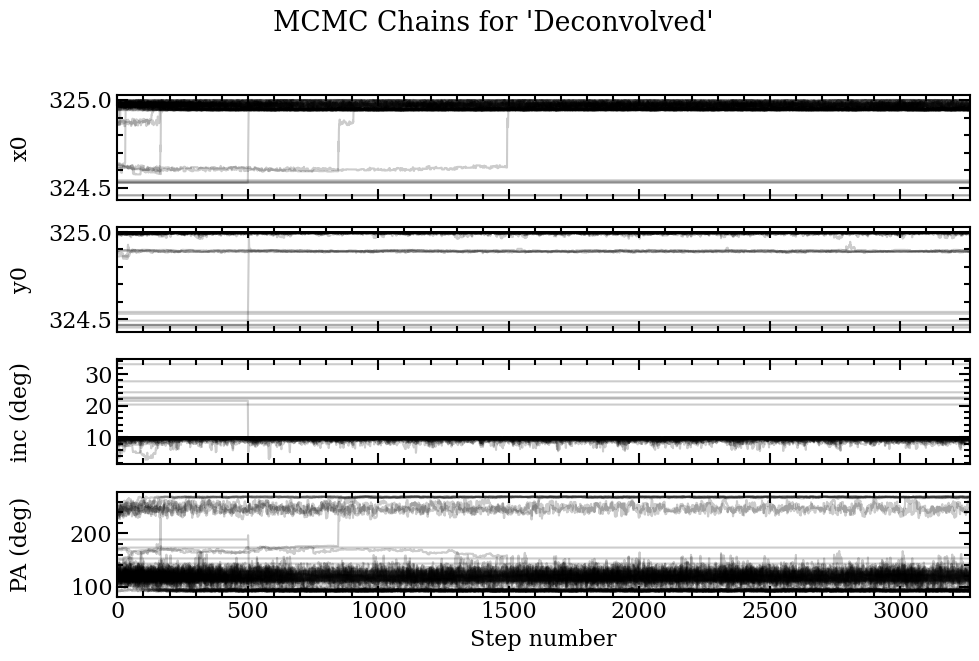

[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours


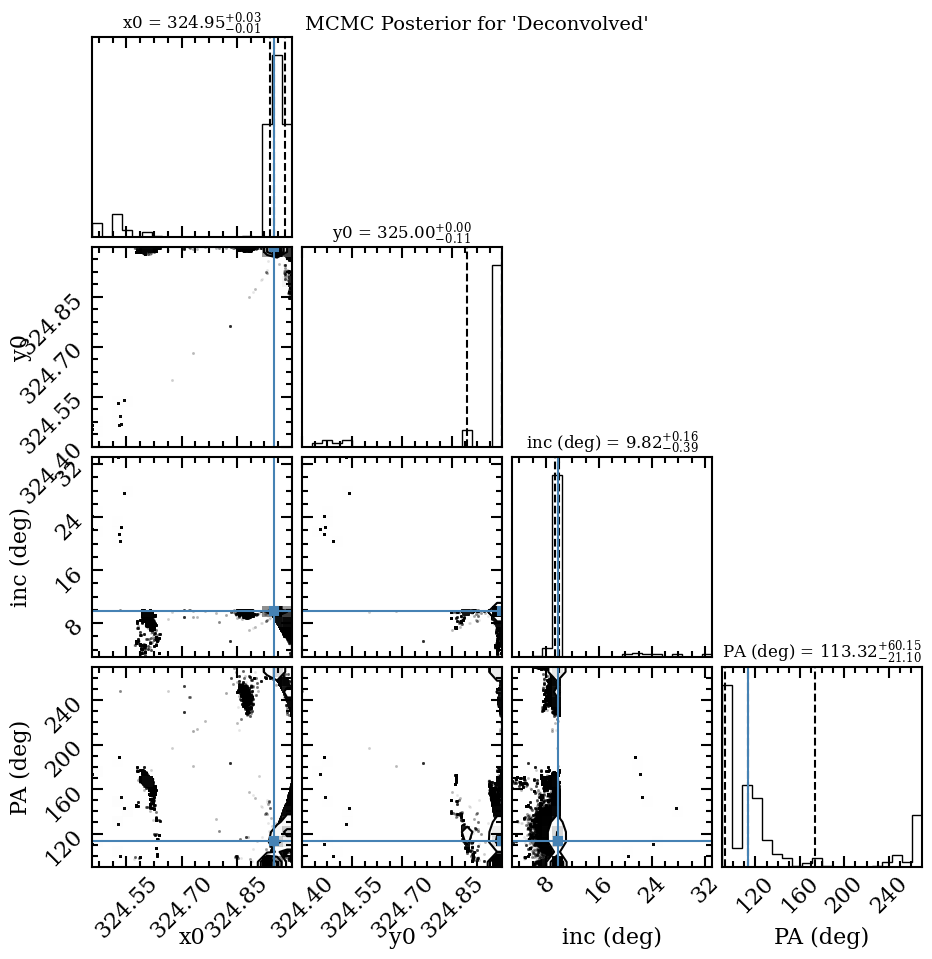


--- Calculating Radial Profiles with Chosen Geometry ---
Using Geometry: Center=(325.00, 324.95), Inc=9.82 deg, PA=113.32 deg
Using ELLIPTICAL bins for profile calculation.
Calculating profiles using 'log' bins...
Outlier clipping fraction: 5.0%
Converted radius to AU using scale 0.0624 arcsec/px and distance 60.1 pc.
Generating final plot...


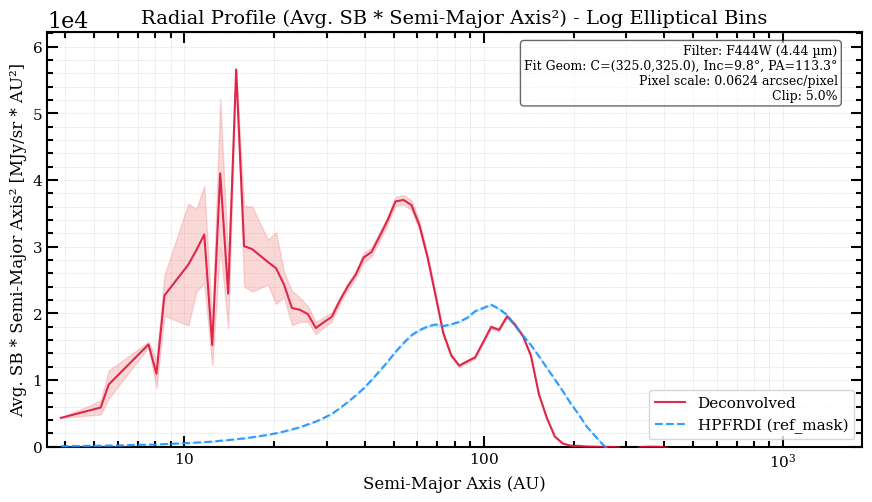

In [69]:
from scipy.special import gammaln
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings
import emcee # MCMC sampler
import corner # Corner plots for MCMC results
from tqdm import tqdm # Progress bar
import multiprocessing
from multiprocessing import Pool

# --- MCMC Fitting Functions ---

def calculate_elliptical_radius_sq(coords_yx, center_yx, inc_rad, pa_rad):
    """
    Calculates the squared 'elliptical radius' for each pixel.
    Points on the same ellipse defined by center, inc, pa will have the same
    elliptical radius, which corresponds to the semi-major axis length.

    Args:
        coords_yx (tuple): Tuple of (y_coords, x_coords) numpy arrays.
        center_yx (tuple): (y0, x0) center coordinates.
        inc_rad (float): Inclination in radians (0=face-on, pi/2=edge-on).
        pa_rad (float): Position angle in radians (counter-clockwise from +x axis).

    Returns:
        np.ndarray: Array of squared elliptical radii for each pixel.
                    Returns None if inc_rad is invalid.
    """
    y_coords, x_coords = coords_yx
    center_y, center_x = center_yx

    # Shift coordinates to be relative to the center
    dy = y_coords - center_y
    dx = x_coords - center_x

    # Rotate coordinates by -pa (clockwise rotation aligns ellipse major axis with x')
    cos_pa = np.cos(-pa_rad)
    sin_pa = np.sin(-pa_rad)
    x_rot = dx * cos_pa - dy * sin_pa
    y_rot = dx * sin_pa + dy * cos_pa

    # Deproject y' coordinate based on inclination
    cos_inc = np.cos(inc_rad)
    if cos_inc <= 1e-6: # Avoid division by zero for edge-on
         # Handle edge-on case: points far from the major axis get large radius_sq
         # This definition might need refinement depending on exact goal for edge-on.
         # Assigning infinity or a very large number might be better if edge-on is unlikely.
         # For now, let's return None to signal an issue in likelihood.
         # print("Warning: Near edge-on inclination encountered.")
         return None # Indicate invalid parameters for likelihood

    y_deproj = y_rot / cos_inc

    # Calculate squared elliptical radius (semi-major axis squared)
    # r_ell^2 = x_rot^2 + (y_rot / cos_inc)^2
    radius_sq = x_rot**2 + y_deproj**2
    return radius_sq

def chi2_to_logL(chi2_value, dof):
    """
    Calculates the log-likelihood of an observed Chi-Square value given its df.
    This is the log of the Chi-Square PDF.

    Args:
        chi2_value (float or np.ndarray): The observed Chi-Square statistic(s).
                                          Must be positive.
        df (float or np.ndarray): The total degrees of freedom. Must be positive.

    Returns:
        float or np.ndarray: The log-likelihood value(s) corresponding to the Chi-Square statistic.
                             Raises ValueError if chi2 or dof are not positive.
    """
    if np.any(chi2_value <= 0) or np.any(dof <= 0):
        raise ValueError("chi2_value and dof must be positive.")
    # Calculate the log-likelihood using the Chi-Square PDF formula
    term1 = -(dof / 2.0) * np.log(2)
    term2 = -gammaln(dof / 2.0)
    term3 = (dof / 2.0 - 1.0) * np.log(chi2_value)
    term4 = -chi2_value / 2.0
    return term1 + term2 + term3 + term4

def log_likelihood(theta, image_data, coords_yx, annuli_edges_r_sq, brightness_floor):
    """
    Calculates the log likelihood for ellipse parameters.
    We define likelihood as inversely proportional to the variance within annuli.
    Maximize: -sum(variance_in_annulus) which minimizes variance.

    Args:
        theta (list/array): Parameters [x0, y0, inc_deg, pa_deg].
        image_data (np.ndarray): The 2D image data.
        coords_yx (tuple): Pre-calculated coordinate grids (y_coords, x_coords).
        annuli_edges_r_sq (np.ndarray): Array of squared semi-major axis defining annulus edges.

    Returns:
        float: Log likelihood value. Returns -np.inf if parameters are invalid
               or no valid pixels are found in annuli.
    """
    x0, y0, inc_deg, pa_deg = theta
    inc_rad = np.radians(inc_deg)
    pa_rad = np.radians(pa_deg)

    # Calculate squared elliptical radius for all pixels
    dist_sq_ell = calculate_elliptical_radius_sq(coords_yx, (y0, x0), inc_rad, pa_rad)

    if dist_sq_ell is None: # Handle invalid inclination from helper func
        return -np.inf
    
    # This sum will be minimized. Log Likelihood = -Sum.
    contributing_annuli_count = 0
    df = 0 # Degrees of freedom for chi-squared
    sum_of_kai_squared = 0.0

    for i in range(len(annuli_edges_r_sq) - 1):
        r_min_sq = annuli_edges_r_sq[i]
        r_max_sq = annuli_edges_r_sq[i+1]
        mask_area = (dist_sq_ell >= r_min_sq) & (dist_sq_ell < r_max_sq)

        if np.any(mask_area):
            pixels_in_annulus = image_data[mask_area]
            valid_pixels = pixels_in_annulus[np.isfinite(pixels_in_annulus)]
            N_k = len(valid_pixels) # Number of valid pixels in annulus k
            df_k = N_k - 1 # Degrees of freedom for chi-squared in annulus k
            # Need at least 2 points for variance
            if df_k > 0:
                mean_brightness_k = np.max(np.mean(valid_pixels),0) # Avoid negative mean
                observed_variance_k = np.var(valid_pixels) # Standard Variance
                expected_variance_k = mean_brightness_k + brightness_floor # Expected brightness variance
                kai_squared_k = N_k * observed_variance_k / expected_variance_k # Chi-squared statistic = (n-1)*(sample variance/expected variance); df_k =N_k - 1
                sum_of_kai_squared += kai_squared_k
                df += df_k # Degrees of freedom for chi-squared
                contributing_annuli_count += 1
                # print(f"Annulus {i}: N_k={N_k}, mean_brightness_k={mean_brightness_k:.2f}, observed_variance_k={observed_variance_k:.2f}, expected_variance_k={expected_variance_k:.2f}, kai_squared_k={kai_squared_k:.2f}")

    if contributing_annuli_count == 0:
        return -np.inf # No data found in any annulus for these parameters

    # Maximize likelihood = Minimize average variance
    log_like = chi2_to_logL(sum_of_kai_squared, df) # Convert chi-squared to log-likelihood

    # Check for NaN/inf result before returning
    if not np.isfinite(log_like):
        return -np.inf

    return log_like

def log_prior(theta, center_yx_guess, center_yx_delta, ny, nx):
    """
    Defines priors for the parameters [x0, y0, inc_deg, pa_deg].

    Args:
        theta (list/array): Parameters [x0, y0, inc_deg, pa_deg].
        center_yx_guess (tuple): Initial guess for center (y, x).
        center_yx_delta (float): Allowed deviation for center from guess (pixels).
        ny, nx (int): Image dimensions.

    Returns:
        float: 0.0 if parameters are within priors, -np.inf otherwise.
    """
    x0, y0, inc_deg, pa_deg = theta
    y_guess, x_guess = center_yx_guess

    # Prior on Center: Uniform within a box around the guess
    # Ensure center stays roughly within image bounds too
    if not (x_guess - center_yx_delta < x0 < x_guess + center_yx_delta and 0 < x0 < nx -1):
        return -np.inf
    if not (y_guess - center_yx_delta < y0 < y_guess + center_yx_delta and 0 < y0 < ny -1):
        return -np.inf

    # Prior on Inclination: Uniform between 0 and 90 degrees
    if not (0.0 <= inc_deg <= 10.0):
        return -np.inf

    # Prior on Position Angle: Uniform between 0 and 180 degrees (or -90 to 90)
    # Ellipse is symmetric after 180 deg rotation
    if not (90.0 <= pa_deg < 270.0):
        return -np.inf

    # If all checks pass:
    return 0.0

def log_probability(theta, image_data, coords_yx, annuli_edges_r_sq, center_yx_guess, center_yx_delta, ny, nx, brightness_floor):
    """
    Combines log prior and log likelihood. This is what emcee samples.
    """
    lp = log_prior(theta, center_yx_guess, center_yx_delta, ny, nx)
    if not np.isfinite(lp):
        return -np.inf # Prior rejected

    ll = log_likelihood(theta, image_data, coords_yx, annuli_edges_r_sq, brightness_floor)
    # Check if likelihood is finite separately
    if not np.isfinite(ll):
        return -np.inf # Likelihood invalid (e.g., bad params, no data)

    return lp + ll


# --- Main Execution ---
if __name__ == "__main__":

    # --- User Choices ---
    
    FIT_ELLIPSE = True         # Set to True to run MCMC fitting
    IMAGE_TO_FIT = img_deconv  # Choose which image to use for fitting (e.g., higher S/N)
    IMAGE_FIT_LABEL = labels[0] # Label for the image used in fitting

    # --- MCMC Parameters ---
    # Define prior ranges and initial guesses
    ny_fit, nx_fit = IMAGE_TO_FIT.shape
    center_y_guess, center_x_guess = ny_fit / 2 - .5, nx_fit / 2 - .5
    center_delta_prior = 0.5 # Allow center to vary by +/- 0.5 pixels from guess
    inc_guess = 5.0          # Initial guess for inclination (degrees)
    pa_guess = 150.0           # Initial guess for PA (degrees)

    # Elliptical annuli for likelihood calculation (use squared radii)
    # Choose a range relevant to the disk structure, avoiding the very center/edges maybe
    fit_min_r_ell_px = 3.0 # Minimum radius in pixels
    # Go out to 3 arcsec or 90% of the image size
    fit_max_r_ell_px = min(ny_fit, nx_fit)*0.9
    if 'wdb' in locals() or 'wdb' in globals():
        try:
            pixel_scale_arcsec = wdb.pxscale.to(u.arcsec/u.pixel).value
            fit_max_r_ell_px = min(fit_max_r_ell_px, 3.0 / pixel_scale_arcsec) # 3 arcsec max
            # print fitting range in pixels and arcsec
            print (f"Pixel range for fitting: {fit_min_r_ell_px:.2f} ({fit_min_r_ell_px*pixel_scale_arcsec:.2f} arcsec) to {fit_max_r_ell_px:.2f} ({fit_max_r_ell_px*pixel_scale_arcsec:.2f} arcsec) px")
        except Exception as e:
            print(f"Warning: Error getting pixel scale ({e}). Using image size limit.")
            # print fitting range in pixels
            print (f"Pixel range for fitting: {fit_min_r_ell_px:.2f} to {fit_max_r_ell_px:.2f} px")
    
    # Create annuli edges with given widen
    annuli_width = 1 # Width of annuli in pixels
    fit_annuli_r_edges = np.arange(fit_min_r_ell_px, fit_max_r_ell_px + 1, annuli_width)
    fit_annuli_r_sq_edges = fit_annuli_r_edges**2

    # MCMC settings
    nwalkers = 64   # Number of MCMC walkers (should be > 2 * ndim)
    ndim = 4        # Number of parameters (x0, y0, inc_deg, pa_deg)
    nsteps = 50000   # Total MCMC steps per walker
    nburn = 1000     # "Burn-in" steps to discard
    brightness_floor_level = 0.05 # Brightness floor level
    
    # --- Calculate the brightness floor value ---
    y_coords_fit, x_coords_fit = np.ogrid[:ny_fit, :nx_fit]
    coords_yx_fit = (y_coords_fit, x_coords_fit)
    dist_sq_fit = (x_coords_fit - center_x_guess)**2 + (y_coords_fit - center_y_guess)**2
    # Create mask for the fitting area
    mask_area = (dist_sq_fit < fit_max_r_ell_px**2)
    IMAGE_TO_FIT_masked = IMAGE_TO_FIT[mask_area]
    brightness_floor_val = np.percentile(IMAGE_TO_FIT_masked[np.isfinite(IMAGE_TO_FIT_masked)], brightness_floor_level*100)
    print(f"Brightness floor value: {brightness_floor_val:.2e} (level: {brightness_floor_level*100:.1f}%)")

    # --- Run MCMC Fitting (if enabled) ---
    best_fit_params = None
    flat_samples = None
    if FIT_ELLIPSE:
        print(f"Starting MCMC fitting for ellipse parameters on '{IMAGE_FIT_LABEL}'...")
        print(f"Priors: Center=({center_y_guess},{center_x_guess})+/-{center_delta_prior}px, Inc=[0,10], PA=[90,270]")
        
        # Determine number of cores to use
        n_cores = multiprocessing.cpu_count()
        use_cores = min(8, n_cores) # Use 8 cores or all available if < 8
        print(f"\nStarting MCMC fitting using {use_cores} / {n_cores} cores...")
        
        # Initial positions for walkers (small ball around guess)
        p0 = np.zeros((nwalkers, ndim))
        p0[:, 0] = center_x_guess + center_delta_prior * (np.random.rand(nwalkers) * 2 - 1) * 0.1 # x0
        p0[:, 1] = center_y_guess + center_delta_prior * (np.random.rand(nwalkers) * 2 - 1) * 0.1 # y0
        p0[:, 2] = np.clip(inc_guess + 10 * np.random.randn(nwalkers), 1, 89) # inc_deg (clipped)
        p0[:, 3] = (pa_guess + 30 * np.random.randn(nwalkers) - 90) % 180.0 + 90 # pa_deg (wrapped)

        # Use a multiprocessing Pool
        # Use 'with Pool...' for proper cleanup
        with Pool(processes=use_cores) as pool:
            # Set up the sampler
            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability,
                args=(IMAGE_TO_FIT, coords_yx_fit, fit_annuli_r_sq_edges,
                    (center_y_guess, center_x_guess), center_delta_prior, ny_fit, nx_fit, brightness_floor_val),
                pool=pool
            )
            # Run MCMC with progress bar
            print(f"Running {nsteps} steps with {nwalkers} walkers...")
            sampler.run_mcmc(p0, nsteps, progress=True)

        # --- Analyze MCMC Results ---
        print(f"MCMC finished. Discarding {nburn} burn-in steps.")
        samples = sampler.get_chain(discard=nburn, thin=15, flat=False) # Shape (nsteps-nburn, nwalkers, ndim)
        flat_samples = sampler.get_chain(discard=nburn, flat=True) # Shape ((nsteps-nburn)*nwalkers, ndim)

        # Check acceptance fraction
        acceptance_fraction = np.mean(sampler.acceptance_fraction)
        print(f"Mean acceptance fraction: {acceptance_fraction:.3f}")
        if not (0.1 < acceptance_fraction < 0.7): # Typical good range
             print("Warning: Acceptance fraction may indicate poor sampling efficiency.")

        # Get best fit parameters (e.g., median of the posterior)
        best_fit_params = []
        param_labels = ["x0", "y0", "inc (deg)", "PA (deg)"]
        print("\n--- MCMC Results (median +/- [16th, 84th] percentiles) ---")
        for i in range(ndim):
            median = np.percentile(flat_samples[:, i], 50)
            p16 = np.percentile(flat_samples[:, i], 16)
            p84 = np.percentile(flat_samples[:, i], 84)
            best_fit_params.append(median)
            print(f"{param_labels[i]:<10s}: {median:.3f} (+{p84-median:.3f} / -{median-p16:.3f})")

        # --- Plot MCMC Results ---
        # 1. Plot Chains
        fig_chains, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
        for i in range(ndim):
            ax = axes[i]
            # Plot samples for each walker over steps
            ax.plot(samples[:, :, i], "k", alpha=0.2) # samples has shape (steps, walkers, dims)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(param_labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)
        axes[-1].set_xlabel("Step number")
        fig_chains.suptitle(f"MCMC Chains for '{IMAGE_FIT_LABEL}'")
        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for suptitle
        plt.show()

        # 2. Corner Plot
        fig_corner = corner.corner(
            flat_samples, labels=param_labels, truths=best_fit_params, # Show median as truth
            quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}
        )
        fig_corner.suptitle(f"MCMC Posterior for '{IMAGE_FIT_LABEL}'", fontsize=14)
        plt.show()

    else:
        print("MCMC fitting disabled (FIT_ELLIPSE=False). Using default center.")
        # Use default center if not fitting
        best_fit_params = [nx // 2, ny // 2, 0.0, 0.0] # x0, y0, inc=0, pa=0


    # --- Now, proceed with Radial Profile Calculation using the BEST FIT parameters ---
    # --- (Or default parameters if FIT_ELLIPSE was False) ---

    print("\n--- Calculating Radial Profiles with Chosen Geometry ---")
    fitted_x0, fitted_y0, fitted_inc_deg, fitted_pa_deg = best_fit_params
    print(f"Using Geometry: Center=({fitted_y0:.2f}, {fitted_x0:.2f}), Inc={fitted_inc_deg:.2f} deg, PA={fitted_pa_deg:.2f} deg")

    # --- User Choices for Profile Calculation ---
    PROFILE_BINNING_MODE = 'log' # 'linear' or 'log'
    PROFILE_OUTLIER_CLIP = 0.05   # Fraction to clip (e.g., 0.05 = 5% total), 0.0 to disable
    PROFILE_USE_ELLIPTICAL_BINS = True # Use elliptical bins based on fit?

    # --- Binning Parameters ---
    linear_bin_size_px = 3
    num_log_bins = 100
    min_radius_px_log = 1.0

    # --- Input Data ---
    labels = ['Deconvolved', 'HPFRDI (ref_mask)']
    colors = ['crimson', 'dodgerblue']
    linestyles = ['-', '--']
    fill_colors = ['lightcoral', 'lightskyblue']

    # --- Determine Max Radius for Profile (use fitted center if available) ---
    # Using the shape of the first image for consistency
    ny_prof, nx_prof = img_deconv.shape
    # Max radius should be calculated relative to the potentially offset center
    # Use distance to corners from fitted center to find max possible radius
    corners = [(0, 0), (0, nx_prof - 1), (ny_prof - 1, 0), (ny_prof - 1, nx_prof - 1)]
    max_dist_sq = 0
    for y_corn, x_corn in corners:
         dist_sq = (x_corn - fitted_x0)**2 + (y_corn - fitted_y0)**2
         max_dist_sq = max(max_dist_sq, dist_sq)
    max_radius_px = int(np.sqrt(max_dist_sq)) # Max distance to any corner

    # --- Calculate Profiles ---
    profiles_mean = []
    profiles_std = []
    radii_plot_list = [] # Store radii for each profile separately now

    # Recalculate coords grid if image shapes differ or for clarity
    y_coords_prof, x_coords_prof = np.ogrid[:ny_prof, :nx_prof]
    coords_yx_prof = (y_coords_prof, x_coords_prof)

    # Calculate distances based on profile binning choice
    if PROFILE_USE_ELLIPTICAL_BINS and FIT_ELLIPSE:
        print("Using ELLIPTICAL bins for profile calculation.")
        dist_sq_prof = calculate_elliptical_radius_sq(
            coords_yx_prof,
            (fitted_y0, fitted_x0),
            np.radians(fitted_inc_deg),
            np.radians(fitted_pa_deg)
        )
        if dist_sq_prof is None:
            print("Error calculating elliptical distances for profile. Aborting.")
            exit()
        # For elliptical bins, radii represent semi-major axis
        profile_radius_label = 'Semi-Major Axis'
    else:
        print("Using CIRCULAR bins for profile calculation.")
        # Standard circular distance from fitted center
        dist_sq_prof = (x_coords_prof - fitted_x0)**2 + (y_coords_prof - fitted_y0)**2
        profile_radius_label = 'Radius'


    print(f"Calculating profiles using '{PROFILE_BINNING_MODE}' bins...")
    print(f"Outlier clipping fraction: {PROFILE_OUTLIER_CLIP*100:.1f}%")

    for i, img in enumerate([img_deconv, img_hpfrdi]):
        if img.shape != (ny_prof, nx_prof):
             print(f"Warning: Shape mismatch for {labels[i]}. Skipping profile.")
             profiles_mean.append(np.array([np.nan]))
             profiles_std.append(np.array([np.nan]))
             radii_plot_list.append(np.array([np.nan]))
             continue

        # --- Binning Setup (inside loop if params might change per image) ---
        if PROFILE_BINNING_MODE == 'log':
            if min_radius_px_log <= 0: exit("min_radius_px_log must be > 0")
            # Define edges based on the distance metric being used (sqrt of dist_sq_prof)
            max_r_val = np.sqrt(np.nanmax(dist_sq_prof)) # Max actual distance value in map
            # Ensure max_radius for binning doesn't exceed max possible distance
            current_max_r = min(max_radius_px, max_r_val)
            if current_max_r <= min_radius_px_log:
                 print(f"Warning: max radius ({current_max_r}) <= min radius ({min_radius_px_log}) for {labels[i]}. Skipping.")
                 profiles_mean.append(np.array([np.nan]))
                 profiles_std.append(np.array([np.nan]))
                 radii_plot_list.append(np.array([np.nan]))
                 continue

            radii_edges = np.logspace(np.log10(min_radius_px_log),
                                      np.log10(current_max_r),
                                      num_log_bins + 1)
            bin_centers = np.sqrt(radii_edges[:-1] * radii_edges[1:]) # Geometric mean
        elif PROFILE_BINNING_MODE == 'linear':
             if linear_bin_size_px <= 0: exit("linear_bin_size_px must be > 0")
             current_max_r = np.sqrt(np.nanmax(dist_sq_prof)) # Max actual distance value
             radii_edges = np.arange(0, min(max_radius_px, current_max_r) + linear_bin_size_px, linear_bin_size_px)
             if radii_edges[-1] > min(max_radius_px, current_max_r): radii_edges = radii_edges[:-1] # Avoid overshooting
             if len(radii_edges) < 2:
                  print(f"Warning: Not enough bins generated for {labels[i]}. Skipping.")
                  profiles_mean.append(np.array([np.nan]))
                  profiles_std.append(np.array([np.nan]))
                  radii_plot_list.append(np.array([np.nan]))
                  continue
             bin_centers = radii_edges[:-1] + (radii_edges[1:] - radii_edges[:-1]) / 2.0 # Arithmetic mean
        else:
            raise ValueError(f"Invalid PROFILE_BINNING_MODE: {PROFILE_BINNING_MODE}")

        radii_edges_sq = radii_edges**2 # Square edges for comparison with dist_sq_prof

        # --- Calculate profile in bins ---
        profile_mean_values = []
        profile_std_values = []

        for j in range(len(radii_edges_sq) - 1):
            r_min_sq = radii_edges_sq[j]
            r_max_sq = radii_edges_sq[j+1]
            # Use the pre-calculated distance map (circular or elliptical)
            mask_area = (dist_sq_prof >= r_min_sq) & (dist_sq_prof < r_max_sq)

            avg_value = np.nan
            std_value = np.nan

            if np.any(mask_area):
                pixels_in_annulus = img[mask_area]
                valid_pixels = pixels_in_annulus[np.isfinite(pixels_in_annulus)]
                valid_pixels_count = len(valid_pixels)
                
                if valid_pixels_count > 0:
                    if PROFILE_OUTLIER_CLIP > 0 and valid_pixels_count > 2:
                        lower_p = (PROFILE_OUTLIER_CLIP / 2.0) * 100
                        upper_p = (1.0 - PROFILE_OUTLIER_CLIP / 2.0) * 100
                        try:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                vmin, vmax = np.percentile(valid_pixels, [lower_p, upper_p])
                            clipped_pixels = valid_pixels[(valid_pixels >= vmin) & (valid_pixels <= vmax)]
                            clipped_pixels_count = len(clipped_pixels)
                            if clipped_pixels_count > 0:
                                avg_value = np.mean(clipped_pixels)
                                std_value = np.std(clipped_pixels) / np.sqrt(clipped_pixels_count) if clipped_pixels_count > 1 else 0.0
                            else: # Fallback if clipping removed all
                                avg_value = np.mean(valid_pixels)
                                std_value = np.std(valid_pixels) / np.sqrt(valid_pixels_count) if valid_pixels_count > 1 else 0.0
                        except IndexError: # Fallback if percentile fails
                            avg_value = np.mean(valid_pixels)
                            std_value = np.std(valid_pixels) / np.sqrt(valid_pixels_count) if valid_pixels_count > 1 else 0.0
                    else: # No clipping
                        avg_value = np.mean(valid_pixels)
                        std_value = np.std(valid_pixels) / np.sqrt(valid_pixels_count) if valid_pixels_count > 1 else 0.0

            profile_mean_values.append(avg_value)
            profile_std_values.append(std_value)

        profiles_mean.append(np.array(profile_mean_values))
        profiles_std.append(np.array(profile_std_values))
        radii_plot_list.append(bin_centers) # Store the bin centers for this profile

    # --- Unit Conversion (Similar to before, but use profile_radius_label) ---
    radii_plot_units = [] # Store unit-converted radii
    x_label_final = f'{profile_radius_label} (pixels)' # Default label
    pixel_scale_arcsec = None
    pixel_scale_au = None
    distance_pc = None

    try:
        if 'wdb' in locals() or 'wdb' in globals():
            pixel_scale_arcsec = wdb.pxscale.to(u.arcsec/u.pixel).value
            pixel_scale_value = pixel_scale_arcsec
            units = 'arcsec'
            if 'distance' in locals() or 'distance' in globals():
                distance_pc = distance
                pixel_scale_au = pixel_scale_arcsec * distance_pc
                x_label_final = f'{profile_radius_label} (AU)'
                print(f"Converted radius to AU using scale {pixel_scale_arcsec:.4f} arcsec/px and distance {distance_pc} pc.")
                for r_px in radii_plot_list: radii_plot_units.append(r_px * pixel_scale_au)
            else:
                 print("Warning: 'distance' variable not found. Cannot convert radius to AU.")
                 pixel_scale_value = pixel_scale_arcsec
                 units = 'arcsec'
                 for r_px in radii_plot_list: radii_plot_units.append(r_px) # Use pixels
        else:
             print("Warning: 'wdb' object not found. Cannot get pixel scale.")
             try: pixel_scale_value=pixel_scale_value; units=units
             except NameError: pixel_scale_value = np.nan; units = "unknown"
             for r_px in radii_plot_list: radii_plot_units.append(r_px) # Use pixels
    except Exception as e:
        print(f"Warning: Error during unit conversion ({e}). Plotting radius in pixels.")
        x_label_final = f'{profile_radius_label} (pixels)'
        try: pixel_scale_value=pixel_scale_value; units=units
        except NameError: pixel_scale_value = np.nan; units = "unknown"
        for r_px in radii_plot_list: radii_plot_units.append(r_px) # Use pixels

    if not radii_plot_units: # Handle case where all profiles failed
         print("Error: No valid profiles were calculated. Cannot plot.")
         exit()

    # --- Plotting (Similar to before, but use radii_plot_units list) ---
    print("Generating final plot...")
    fig_radial, ax_radial = plt.subplots(figsize=(9, 6))

    y_label = f'Avg. SB * {profile_radius_label}² [Pixel Units * Pixel²]' # Default Y label
    y_units_str = 'Pixel Units'

    all_y_min = []
    all_y_max = []
    max_r_plot = 0 # Find max radius plotted across all profiles

    for i in range(len(profiles_mean)):
        # Get the correct radius array for this profile
        radii_plot = radii_plot_units[i]

        # Filter out NaNs in mean, std dev, and radii
        valid_mask = (
            np.isfinite(profiles_mean[i]) &
            np.isfinite(profiles_std[i]) &
            np.isfinite(radii_plot) &
            (radii_plot > 0)
        )

        if np.any(valid_mask):
            r_plot_valid = radii_plot[valid_mask]
            mean_valid = profiles_mean[i][valid_mask]
            std_valid = profiles_std[i][valid_mask]

            sb_r_squared = mean_valid * r_plot_valid**2
            err_sb_r_squared = std_valid * r_plot_valid**2

            ax_radial.plot(r_plot_valid, sb_r_squared,
                           label=labels[i], color=colors[i], linestyle=linestyles[i],
                           linewidth=1.5, alpha=0.9, zorder=10)

            ax_radial.fill_between(r_plot_valid,
                                   sb_r_squared - err_sb_r_squared,
                                   sb_r_squared + err_sb_r_squared,
                                   color=fill_colors[i], alpha=0.3,
                                   label='_nolegend_', zorder=5)

            # Update Y label units based on X label units
            if i == 0: # Only need to determine units string once
                 unit_suffix = "Pixels²"
                 if 'AU' in x_label_final: unit_suffix = "AU²"
                 try:
                     y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
                     y_label = f'Avg. SB * {profile_radius_label}² [{y_units_str} * {unit_suffix}]'
                 except Exception:
                     y_label = f'Avg. SB * {profile_radius_label}² [Image Units * {unit_suffix}]'

            # Track min/max for axis limits
            all_y_min.append(np.nanmin(sb_r_squared - err_sb_r_squared))
            all_y_max.append(np.nanmax(sb_r_squared + err_sb_r_squared))
            max_r_plot = max(max_r_plot, np.nanmax(r_plot_valid))

        else:
             print(f"Warning: No valid data points found for profile: {labels[i]}")

    # --- Plot Styling ---
    ax_radial.set_xlabel(x_label_final, fontsize=12)
    ax_radial.set_ylabel(y_label, fontsize=12) # Use the determined y_label
    bin_desc = f"{PROFILE_BINNING_MODE.capitalize()} {'Elliptical ' if PROFILE_USE_ELLIPTICAL_BINS and FIT_ELLIPSE else 'Circular '}Bins"
    ax_radial.set_title(f'Radial Profile (Avg. SB * {profile_radius_label}²) - {bin_desc}', fontsize=14)

    # Add text box with fit info if available
    scale_text = f"{pixel_scale_value:.4f} {units}/pixel" if np.isfinite(pixel_scale_value) else "Unknown"
    clip_text = f"Clip: {PROFILE_OUTLIER_CLIP*100:.1f}%" if PROFILE_OUTLIER_CLIP > 0 else "Clip: None"
    fit_text = ""
    if FIT_ELLIPSE and best_fit_params:
        fit_text = (f"Fit Geom: C=({best_fit_params[1]:.1f},{best_fit_params[0]:.1f}), "
                    f"Inc={best_fit_params[2]:.1f}°, PA={best_fit_params[3]:.1f}°\n")

    textstr = f"Filter: {info_str}\n{fit_text}Pixel scale: {scale_text}\n{clip_text}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.6)
    ax_radial.text(0.97, 0.97, textstr, transform=ax_radial.transAxes,
                   fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=props)

    # Set scales
    if PROFILE_BINNING_MODE == 'log': # Often want log x-scale for log bins
         ax_radial.set_xscale('log')
    else:
         ax_radial.set_xscale('linear')

    # Set y-axis limits
    if all_y_min and all_y_max:
         plot_min_y = max(0, np.nanmin(all_y_min)) * 0.9
         plot_max_y = np.nanmax(all_y_max) * 1.1
         if plot_min_y < plot_max_y: ax_radial.set_ylim(bottom=plot_min_y, top=plot_max_y)
         else: ax_radial.set_ylim(bottom=0)
    else: ax_radial.set_ylim(bottom=0)

    # Set x-axis limits
    valid_radii_all = []
    for r in radii_plot_units: valid_radii_all.extend(r[np.isfinite(r) & (r > 0)])
    if valid_radii_all:
        min_plot_radius = np.min(valid_radii_all)
        max_plot_radius = np.max(valid_radii_all)
        if ax_radial.get_xscale() == 'log':
            ax_radial.set_xlim(left=min_plot_radius * 0.9, right=max_plot_radius * 1.1)
        else:
             start_radius = 0 if PROFILE_BINNING_MODE=='linear' else min_plot_radius * 0.9
             ax_radial.set_xlim(left=start_radius, right=max_plot_radius * 1.05)
    else: # Fallback
        fallback_min = (min_radius_px_log if PROFILE_BINNING_MODE=='log' else 1) * (pixel_scale_au if pixel_scale_au else 1)
        fallback_max = max_radius_px * (pixel_scale_au if pixel_scale_au else 1)
        ax_radial.set_xlim(left=fallback_min * 0.9, right=fallback_max * 1.1)

    # Scientific notation for y-axis
    ax_radial.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    ax_radial.legend(fontsize=11)
    ax_radial.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
    ax_radial.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for title/textbox
    plt.show()

Generating final plot...


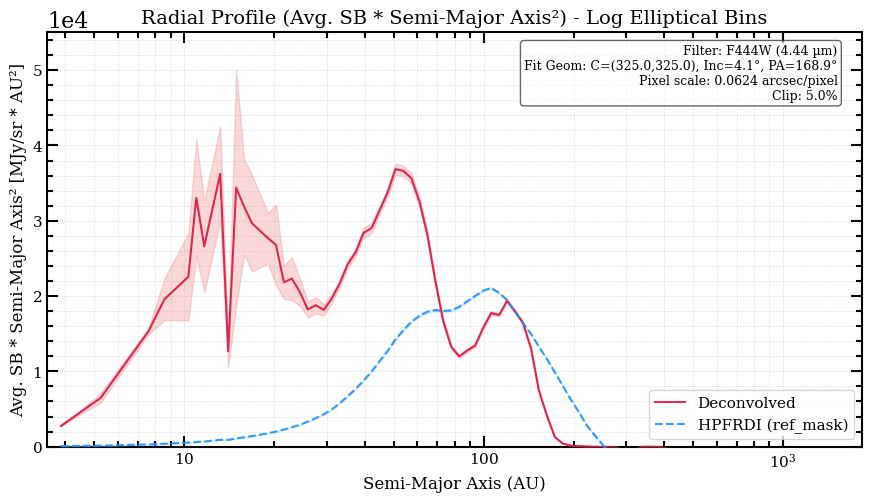

In [ ]:
if __name__ == "__main__":
    best_fit_params[2] = 4.11
    best_fit_params[3] = 168.86
    # --- Plotting (Similar to before, but use radii_plot_units list) ---
    print("Generating final plot...")
    fig_radial, ax_radial = plt.subplots(figsize=(9, 6))

    y_label = f'Avg. SB * {profile_radius_label}² [Pixel Units * Pixel²]' # Default Y label
    y_units_str = 'Pixel Units'

    all_y_min = []
    all_y_max = []
    max_r_plot = 0 # Find max radius plotted across all profiles

    for i in range(len(profiles_mean)):
        # Get the correct radius array for this profile
        radii_plot = radii_plot_units[i]

        # Filter out NaNs in mean, std dev, and radii
        valid_mask = (
            np.isfinite(profiles_mean[i]) &
            np.isfinite(profiles_std[i]) &
            np.isfinite(radii_plot) &
            (radii_plot > 0)
        )

        if np.any(valid_mask):
            r_plot_valid = radii_plot[valid_mask]
            mean_valid = profiles_mean[i][valid_mask]
            std_valid = profiles_std[i][valid_mask]

            sb_r_squared = mean_valid * r_plot_valid**2
            err_sb_r_squared = std_valid * r_plot_valid**2

            ax_radial.plot(r_plot_valid, sb_r_squared,
                           label=labels[i], color=colors[i], linestyle=linestyles[i],
                           linewidth=1.5, alpha=0.9, zorder=10)

            ax_radial.fill_between(r_plot_valid,
                                   sb_r_squared - err_sb_r_squared,
                                   sb_r_squared + err_sb_r_squared,
                                   color=fill_colors[i], alpha=0.3,
                                   label='_nolegend_', zorder=5)

            # Update Y label units based on X label units
            if i == 0: # Only need to determine units string once
                 unit_suffix = "Pixels²"
                 if 'AU' in x_label_final: unit_suffix = "AU²"
                 try:
                     y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
                     y_label = f'Avg. SB * {profile_radius_label}² [{y_units_str} * {unit_suffix}]'
                 except Exception:
                     y_label = f'Avg. SB * {profile_radius_label}² [Image Units * {unit_suffix}]'

            # Track min/max for axis limits
            all_y_min.append(np.nanmin(sb_r_squared - err_sb_r_squared))
            all_y_max.append(np.nanmax(sb_r_squared + err_sb_r_squared))
            max_r_plot = max(max_r_plot, np.nanmax(r_plot_valid))

        else:
             print(f"Warning: No valid data points found for profile: {labels[i]}")

    # --- Plot Styling ---
    ax_radial.set_xlabel(x_label_final, fontsize=12)
    ax_radial.set_ylabel(y_label, fontsize=12) # Use the determined y_label
    bin_desc = f"{PROFILE_BINNING_MODE.capitalize()} {'Elliptical ' if PROFILE_USE_ELLIPTICAL_BINS and FIT_ELLIPSE else 'Circular '}Bins"
    ax_radial.set_title(f'Radial Profile (Avg. SB * {profile_radius_label}²) - {bin_desc}', fontsize=14)

    # Add text box with fit info if available
    scale_text = f"{pixel_scale_value:.4f} {units}/pixel" if np.isfinite(pixel_scale_value) else "Unknown"
    clip_text = f"Clip: {PROFILE_OUTLIER_CLIP*100:.1f}%" if PROFILE_OUTLIER_CLIP > 0 else "Clip: None"
    fit_text = ""
    if FIT_ELLIPSE and best_fit_params:
        fit_text = (f"Fit Geom: C=({best_fit_params[1]:.1f},{best_fit_params[0]:.1f}), "
                    f"Inc={best_fit_params[2]:.1f}°, PA={best_fit_params[3]:.1f}°\n")

    textstr = f"Filter: {info_str}\n{fit_text}Pixel scale: {scale_text}\n{clip_text}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.6)
    ax_radial.text(0.97, 0.97, textstr, transform=ax_radial.transAxes,
                   fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=props)

    # Set scales
    if PROFILE_BINNING_MODE == 'log': # Often want log x-scale for log bins
         ax_radial.set_xscale('log')
    else:
         ax_radial.set_xscale('linear')

    # Set y-axis limits
    if all_y_min and all_y_max:
         plot_min_y = max(0, np.nanmin(all_y_min)) * 0.9
         plot_max_y = np.nanmax(all_y_max) * 1.1
         if plot_min_y < plot_max_y: ax_radial.set_ylim(bottom=plot_min_y, top=plot_max_y)
         else: ax_radial.set_ylim(bottom=0)
    else: ax_radial.set_ylim(bottom=0)

    # Set x-axis limits
    valid_radii_all = []
    for r in radii_plot_units: valid_radii_all.extend(r[np.isfinite(r) & (r > 0)])
    if valid_radii_all:
        min_plot_radius = np.min(valid_radii_all)
        max_plot_radius = np.max(valid_radii_all)
        if ax_radial.get_xscale() == 'log':
            ax_radial.set_xlim(left=min_plot_radius * 0.9, right=max_plot_radius * 1.1)
        else:
             start_radius = 0 if PROFILE_BINNING_MODE=='linear' else min_plot_radius * 0.9
             ax_radial.set_xlim(left=start_radius, right=max_plot_radius * 1.05)
    else: # Fallback
        fallback_min = (min_radius_px_log if PROFILE_BINNING_MODE=='log' else 1) * (pixel_scale_au if pixel_scale_au else 1)
        fallback_max = max_radius_px * (pixel_scale_au if pixel_scale_au else 1)
        ax_radial.set_xlim(left=fallback_min * 0.9, right=fallback_max * 1.1)

    # Scientific notation for y-axis
    ax_radial.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    ax_radial.legend(fontsize=11)
    ax_radial.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
    ax_radial.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for title/textbox
    plt.show()

In [17]:
import time
import numpy as np


def log_prob(theta):
    t = time.time() + np.random.uniform(0.005, 0.008)
    while True:
        if time.time() >= t:
            break
    return -0.5 * np.sum(theta**2)

In [20]:
import emcee

np.random.seed(42)
initial = np.random.randn(32, 5)
nwalkers, ndim = initial.shape
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
print("Running MCMC with {0} walkers and {1} dimensions...".format(nwalkers, ndim))
start = time.time()
sampler.run_mcmc(initial, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

Running MCMC with 32 walkers and 5 dimensions...


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]

Serial took 21.2 seconds


In [19]:
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initial, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

100%|██████████| 100/100 [00:01<00:00, 53.38it/s]


Multiprocessing took 1.9 seconds
11.2 times faster than serial


--- Phase 1: Finding Ring Boundaries ---
Calculating initial circular profile (binsize=2px)
Found 2 potential boundary radii: [ 79. 143.]

Defined Ring Radial Ranges (pixels):
  Ring 1: 1.00 - 79.00
  Ring 2: 79.00 - 143.00
  Ring 3: 143.00 - 223.00


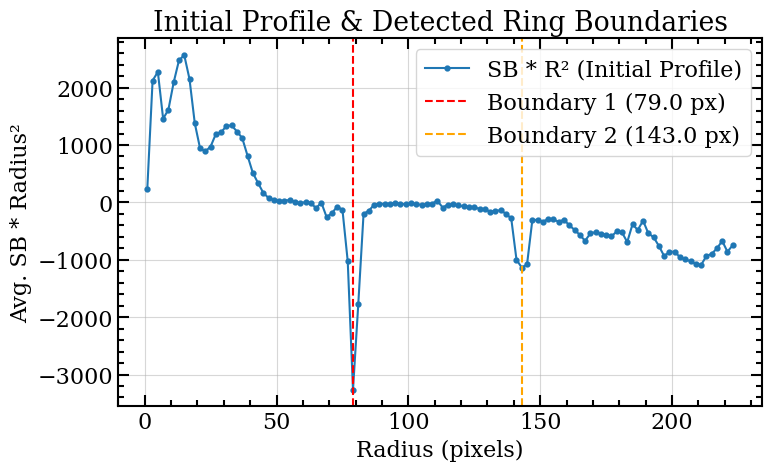


--- Phase 2: Fitting Rings Independently ---

Fitting Ring 1 (R = 1.0 - 79.0 px)...


100%|██████████| 100000/100000 [1:46:33<00:00, 15.64it/s]


  Mean acceptance fraction: 0.615
  --- Results for Ring 1 ---
  inc (deg) : 4.46 (+3.02 / -3.04)
  PA (deg)  : 135.82 (+89.39 / -93.70)


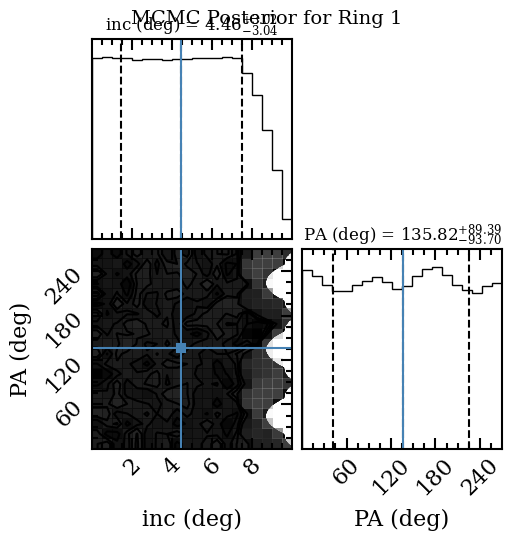


Fitting Ring 2 (R = 79.0 - 143.0 px)...


100%|██████████| 100000/100000 [1:56:20<00:00, 14.33it/s]


  Mean acceptance fraction: 0.608
  --- Results for Ring 2 ---
  inc (deg) : 4.91 (+3.44 / -3.37)
  PA (deg)  : 134.93 (+92.08 / -91.96)


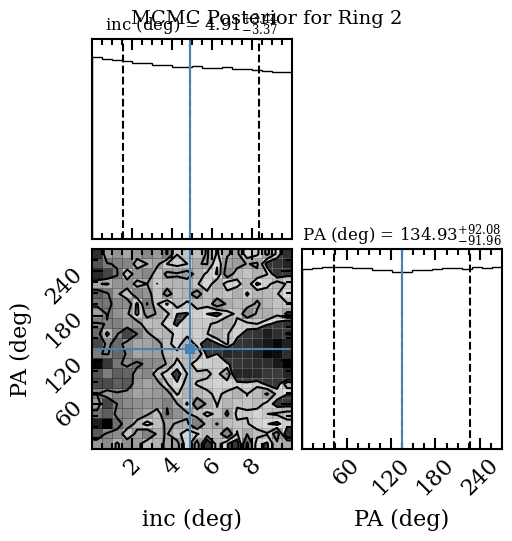


Fitting Ring 3 (R = 143.0 - 223.0 px)...


100%|██████████| 100000/100000 [2:10:45<00:00, 12.75it/s] 


  Mean acceptance fraction: 0.596
  --- Results for Ring 3 ---
  inc (deg) : 5.04 (+3.47 / -3.43)
  PA (deg)  : 136.74 (+89.47 / -93.14)


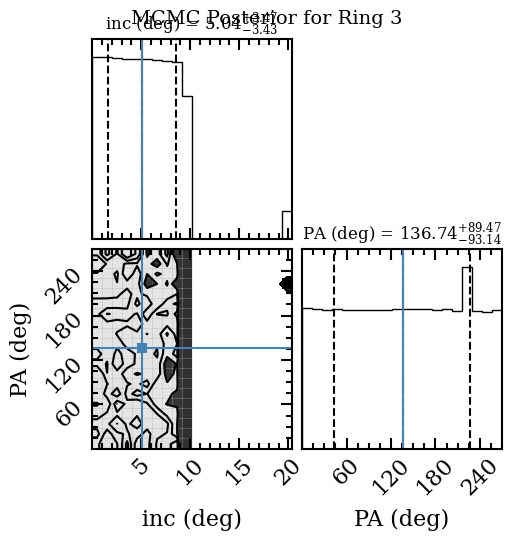


--- Phase 3: Calculating Final Composite Profile ---
Calculating composite profile for: Deconvolved
Calculating composite profile for: HPFRDI (ref_mask)

--- Phase 4: Plotting Final Composite Profile ---
Converted radius to AU: scale=0.0624 arcsec/px, dist=60.1 pc.


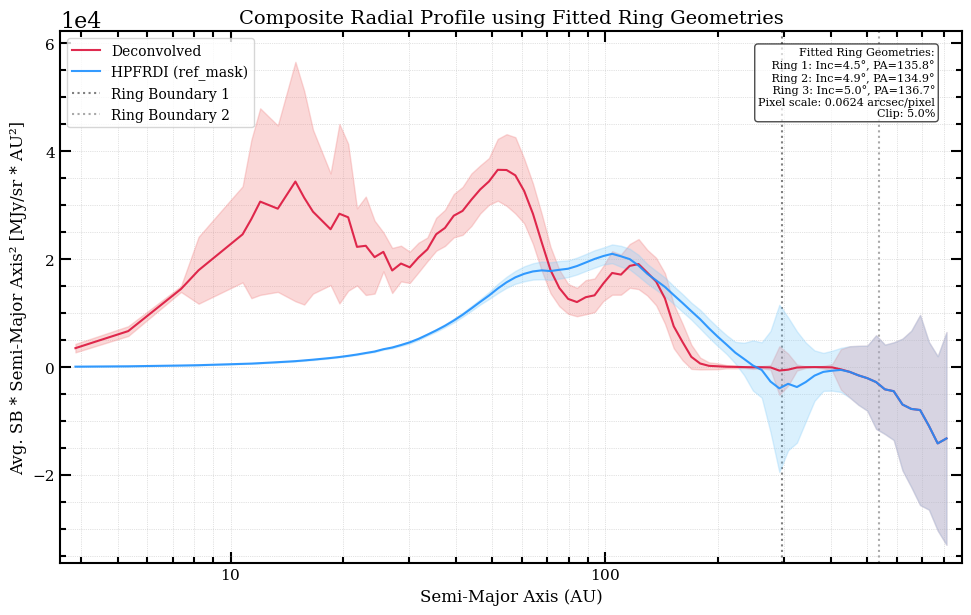

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings
import emcee # MCMC sampler
import corner # Corner plots for MCMC results
from tqdm import tqdm # Progress bar
import multiprocessing
from multiprocessing import Pool
from scipy.signal import find_peaks, savgol_filter # For finding profile drops
from skimage.transform import downscale_local_mean # Optional downsampling
import numba # Optional for speedup

# --- Assume previous setup code exists ---
# Including dummy data generation or loading real data (img_deconv, img_hpfrdi)
# and dummy/real wdb, distance, info_str etc.
# Make sure calculate_radial_profile (original circular one) is available
# or define a simplified version here.

# Example simplified circular profile function (modify if needed)
def calculate_circular_profile_basic(image_data, center_yx, max_radius_px, bin_size_px=1):
    ny, nx = image_data.shape
    center_y, center_x = center_yx
    y, x = np.ogrid[:ny, :nx]
    dist_sq = (x - center_x)**2 + (y - center_y)**2
    radii_edges = np.arange(0, max_radius_px + bin_size_px, bin_size_px)
    bin_centers = radii_edges[:-1] + bin_size_px / 2.0
    profile_values = np.zeros_like(bin_centers) * np.nan
    for i in range(len(radii_edges) - 1):
        mask = (dist_sq >= radii_edges[i]**2) & (dist_sq < radii_edges[i+1]**2)
        if np.any(mask):
            profile_values[i] = np.nanmean(image_data[mask])
    return bin_centers, profile_values

# --- MCMC Fitting Functions (Adapted for single ring fit) ---

# Use the Numba-optimized version if desired and tested
# @numba.njit(fastmath=True, cache=True)
def calculate_elliptical_radius_sq(y_coords, x_coords, center_y, center_x, inc_rad, pa_rad):
    # Numba works best with simple arguments, unpack tuples outside if needed
    # Reimplement the logic using basic NumPy operations compatible with Numba
    dy = y_coords - center_y
    dx = x_coords - center_x
    cos_pa = np.cos(-pa_rad)
    sin_pa = np.sin(-pa_rad)
    x_rot = dx * cos_pa - dy * sin_pa
    y_rot = dx * sin_pa + dy * cos_pa
    cos_inc = np.cos(inc_rad)
    # Handle edge-on case - return negative value for check
    if cos_inc <= 1e-9:
        return np.full_like(x_rot, -1.0) # Return array of -1s

    y_deproj = y_rot / cos_inc
    radius_sq = x_rot**2 + y_deproj**2
    return radius_sq

def log_likelihood_ring(theta_ring,  # Only [inc_deg, pa_deg]
                         fixed_center_yx,
                         image_data,
                         coords_yx,
                         r_min_ring_px, # Min radius defining this ring
                         r_max_ring_px, # Max radius defining this ring
                         annuli_edges_r_sq_fit): # Annuli *within* the ring for variance calc
    """
    Log likelihood for a *single ring*, using data only within its radial bounds.
    Minimizes variance within elliptical annuli *within* the ring boundaries.
    """
    inc_deg, pa_deg = theta_ring
    inc_rad = np.radians(inc_deg)
    pa_rad = np.radians(pa_deg)
    center_y, center_x = fixed_center_yx
    y_coords, x_coords = coords_yx # Full image coordinate grids

    # Calculate elliptical distance for the *entire* image using current geometry
    dist_sq_ell = calculate_elliptical_radius_sq(y_coords, x_coords, center_y, center_x, inc_rad, pa_rad)

    if np.any(dist_sq_ell < 0): # Check for Numba error indicator or calculation failure
        return -np.inf

    # --- Filter pixels belonging to the CURRENT RING ---
    # Use elliptical distance for this check!
    ring_mask = (dist_sq_ell >= r_min_ring_px**2) & (dist_sq_ell < r_max_ring_px**2)
    if not np.any(ring_mask):
        return -np.inf # No pixels in this ring for this geometry

    # Filter the image data and elliptical distances to only include the ring
    image_data_ring = image_data[ring_mask]
    dist_sq_ell_ring = dist_sq_ell[ring_mask]

    # --- Calculate variance within elliptical annuli *inside* the ring ---
    total_variance = 0
    valid_annuli_count = 0
    for i in range(len(annuli_edges_r_sq_fit) - 1):
        r_min_sq = annuli_edges_r_sq_fit[i]
        r_max_sq = annuli_edges_r_sq_fit[i+1]

        # Select pixels from the *already filtered* ring data
        mask_annulus_in_ring = (dist_sq_ell_ring >= r_min_sq) & (dist_sq_ell_ring < r_max_sq)

        if np.any(mask_annulus_in_ring):
            pixels_in_annulus = image_data_ring[mask_annulus_in_ring]
            # Already checked for NaNs when creating ring_mask potentially, but double check
            valid_pixels = pixels_in_annulus[np.isfinite(pixels_in_annulus)]

            if len(valid_pixels) >= 2:
                 variance = np.var(valid_pixels)
                 total_variance += variance # Could add weighting here (e.g., * sqrt(N))
                 valid_annuli_count += 1

    if valid_annuli_count == 0:
        return -np.inf # No valid annuli found within the ring

    log_like = - (total_variance / valid_annuli_count) # Minimize average variance

    if not np.isfinite(log_like): return -np.inf
    return log_like


def log_prior_ring(theta_ring):
    """ Priors for [inc_deg, pa_deg] """
    inc_deg, pa_deg = theta_ring
    # Inclination: 0 to 90 degrees
    if not (0.0 <= inc_deg <= 10.0): return -np.inf
    # Position Angle: 90 to 270 degrees
    if not (0.0 <= pa_deg < 270.0): return -np.inf
    return 0.0

def log_probability_ring(theta_ring, fixed_center_yx, image_data, coords_yx,
                           r_min_ring_px, r_max_ring_px, annuli_edges_r_sq_fit):
    """ Combines prior and likelihood for a single ring fit """
    lp = log_prior_ring(theta_ring)
    if not np.isfinite(lp): return -np.inf

    ll = log_likelihood_ring(theta_ring, fixed_center_yx, image_data, coords_yx,
                             r_min_ring_px, r_max_ring_px, annuli_edges_r_sq_fit)
    if not np.isfinite(ll): return -np.inf
    return lp + ll

# --- Helper function to find profile drops ---
def find_profile_drops(radii, profile, num_drops=2, smooth_window=7, prominence_rel=0.1):
    """
    Finds significant drops in a radial profile.

    Args:
        radii (np.ndarray): Radius values.
        profile (np.ndarray): Profile values (e.g., SB*R^2).
        num_drops (int): Number of drops to find.
        smooth_window (int): Window size for Savitzky-Golay smoothing (odd number > polyorder).
        prominence_rel (float): Minimum prominence relative to the profile max to be considered significant.

    Returns:
        np.ndarray: Radii corresponding to the most significant drops, sorted by radius.
                    Returns fewer than num_drops if not enough significant drops are found.
    """
    if len(radii) != len(profile):
        raise ValueError("Radii and profile must have the same length.")
    if smooth_window % 2 == 0 or smooth_window <= 3: smooth_window = 5 # Ensure odd and > 3

    valid_mask = np.isfinite(profile)
    if np.sum(valid_mask) < smooth_window: # Need enough points to smooth
        print("Warning: Not enough valid points in profile to find drops reliably.")
        return np.array([])

    r_valid = radii[valid_mask]
    p_valid = profile[valid_mask]

    # Smooth the profile
    try:
        profile_smooth = savgol_filter(p_valid, window_length=smooth_window, polyorder=2)
    except ValueError:
         print("Warning: Smoothing failed, using original profile.")
         profile_smooth = p_valid # Fallback

    # Find local minima (peaks of the negative profile)
    # Use prominence relative to overall scale to filter small wiggles
    min_prominence = prominence_rel * (np.nanmax(profile_smooth) - np.nanmin(profile_smooth))
    minima_indices, properties = find_peaks(-profile_smooth, prominence=min_prominence)

    if len(minima_indices) == 0:
        print("Warning: No significant minima found in the profile.")
        return np.array([])

    # Sort minima by their prominence (larger drop = more prominent)
    prominences = properties['prominences']
    sorted_indices = np.argsort(prominences)[::-1] # Sort descending by prominence

    # Select the top 'num_drops' most prominent minima
    selected_minima_indices = minima_indices[sorted_indices[:num_drops]]

    # Get the corresponding radii and sort them
    drop_radii = np.sort(r_valid[selected_minima_indices])

    print(f"Found {len(drop_radii)} potential boundary radii: {np.round(drop_radii, 2)}")
    return drop_radii


# --- Main Execution ---
if __name__ == "__main__":

    # --- User Choices ---
    FIT_RINGS = True           # Set to True to run MCMC fitting for rings
    IMAGE_TO_FIT = img_deconv  # Choose which image to use for finding boundaries and fitting
    IMAGE_FIT_LABEL = labels[0]
    FIXED_CENTER_YX = (IMAGE_TO_FIT.shape[0] // 2, IMAGE_TO_FIT.shape[1] // 2) # Fix center
    PROFILE_OUTLIER_CLIP = 0.05 # Clipping for *final* profile calculation

    # --- Parameters for Boundary Finding ---
    boundary_profile_max_r_px = min(FIXED_CENTER_YX[0], FIXED_CENTER_YX[1]) # Go to edge for profile
    boundary_profile_binsize = 2 # Binsize for initial profile
    boundary_smooth_window = 9   # Smoothing for finding drops
    boundary_prominence_rel = 0.1 # Relative prominence threshold for drops

    # --- MCMC Parameters (Per Ring) ---
    mcmc_nwalkers = 64   # Number of walkers per fit (ndim=2, so > 4)
    mcmc_nsteps = 100000    # Total MCMC steps per walker
    mcmc_nburn = 10000     # Burn-in steps to discard
    mcmc_num_fit_annuli = 15 # Number of annuli *within* each ring for likelihood calc
    # Optional downsampling *during* MCMC fit
    mcmc_downsample_factor = 1 # Set > 1 to downsample (e.g., 2)

    # --- Parallelization ---
    use_parallel = True
    n_cores = multiprocessing.cpu_count()
    # Find optimal core count based on previous tests (e.g., 4) or system config
    mcmc_use_cores = 4 if use_parallel else 1
    if mcmc_use_cores > n_cores: mcmc_use_cores = n_cores

    # --- Phase 1: Calculate Initial Profile & Find Boundaries ---
    print("--- Phase 1: Finding Ring Boundaries ---")
    print(f"Calculating initial circular profile (binsize={boundary_profile_binsize}px)")
    radii_circ, profile_circ = calculate_circular_profile_basic(
        IMAGE_TO_FIT, FIXED_CENTER_YX, boundary_profile_max_r_px, boundary_profile_binsize
    )

    # Calculate SB * R^2
    sb_r2 = profile_circ * radii_circ**2
    valid_sb_mask = np.isfinite(radii_circ) & np.isfinite(sb_r2)
    radii_circ_valid = radii_circ[valid_sb_mask]
    sb_r2_valid = sb_r2[valid_sb_mask]

    if len(radii_circ_valid) < boundary_smooth_window:
        print("Error: Initial profile has too few points. Cannot find boundaries.")
        exit()

    # Find the two most significant drops
    radii_boundaries = find_profile_drops(
        radii_circ_valid, sb_r2_valid,
        num_drops=2,
        smooth_window=boundary_smooth_window,
        prominence_rel=boundary_prominence_rel
    )

    # Define ring radial ranges
    # Use a small minimum inner radius (e.g., first bin center)
    min_radius_overall_px = radii_circ_valid[0] if len(radii_circ_valid)>0 else 1.0
    max_radius_overall_px = radii_circ_valid[-1] if len(radii_circ_valid)>0 else boundary_profile_max_r_px

    if len(radii_boundaries) == 2:
        r_bound_1, r_bound_2 = radii_boundaries
        ring_definitions = [
            {'name': 'Ring 1', 'r_min': min_radius_overall_px, 'r_max': r_bound_1},
            {'name': 'Ring 2', 'r_min': r_bound_1, 'r_max': r_bound_2},
            {'name': 'Ring 3', 'r_min': r_bound_2, 'r_max': max_radius_overall_px},
        ]
    elif len(radii_boundaries) == 1:
        print("Warning: Found only 1 significant boundary. Defining 2 rings.")
        r_bound_1 = radii_boundaries[0]
        ring_definitions = [
            {'name': 'Ring 1', 'r_min': min_radius_overall_px, 'r_max': r_bound_1},
            {'name': 'Ring 2 (Outer)', 'r_min': r_bound_1, 'r_max': max_radius_overall_px},
        ]
    else:
        print("Warning: Could not find 2 significant boundaries. Defining 1 ring (outer).")
        ring_definitions = [
            {'name': 'Outer Disk', 'r_min': min_radius_overall_px, 'r_max': max_radius_overall_px},
        ]

    print("\nDefined Ring Radial Ranges (pixels):")
    for ring in ring_definitions:
        print(f"  {ring['name']}: {ring['r_min']:.2f} - {ring['r_max']:.2f}")

    # Plot initial profile and boundaries
    plt.figure(figsize=(8, 5))
    plt.plot(radii_circ_valid, sb_r2_valid, '.-', label='SB * R² (Initial Profile)')
    colors = ['red', 'orange', 'magenta']
    for i, r_b in enumerate(radii_boundaries):
        plt.axvline(r_b, color=colors[i % len(colors)], linestyle='--', label=f'Boundary {i+1} ({r_b:.1f} px)')
    plt.xlabel('Radius (pixels)')
    plt.ylabel('Avg. SB * Radius²')
    plt.title('Initial Profile & Detected Ring Boundaries')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Phase 2: Fit Each Ring Independently ---
    fit_results_rings = {} # Store results {ring_name: {'params': [inc, pa], 'samples': samples}}

    if FIT_RINGS:
        print("\n--- Phase 2: Fitting Rings Independently ---")
        ny_fit, nx_fit = IMAGE_TO_FIT.shape
        # Pre-calculate full coordinate grids once
        y_coords_full, x_coords_full = np.ogrid[:ny_fit, :nx_fit]
        coords_yx_full = (y_coords_full, x_coords_full)

        # --- Optional Downsampling ---
        if mcmc_downsample_factor > 1:
             print(f"Downsampling image by {mcmc_downsample_factor}x for MCMC fits...")
             factor = int(mcmc_downsample_factor)
             image_fit_eff = downscale_local_mean(IMAGE_TO_FIT, (factor, factor))
             ny_fit_eff, nx_fit_eff = image_fit_eff.shape
             y_coords_eff, x_coords_eff = np.ogrid[:ny_fit_eff, :nx_fit_eff]
             coords_yx_eff = (y_coords_eff, x_coords_eff)
             center_yx_eff = (FIXED_CENTER_YX[0] / factor, FIXED_CENTER_YX[1] / factor)
        else:
             factor = 1
             image_fit_eff = IMAGE_TO_FIT
             coords_yx_eff = coords_yx_full
             center_yx_eff = FIXED_CENTER_YX
        # -----------------------------

        for i, ring in enumerate(ring_definitions):
            print(f"\nFitting {ring['name']} (R = {ring['r_min']:.1f} - {ring['r_max']:.1f} px)...")

            # Define annuli *within* this ring for likelihood variance calculation
            # Scale ring boundaries if downsampling
            r_min_eff = ring['r_min'] / factor
            r_max_eff = ring['r_max'] / factor

            # Use log or linear spacing for annuli within the ring? Log is often good.
            # Ensure min radius for logspace is positive and less than max
            log_min_r = max(0.5 / factor, r_min_eff) # Avoid log(0) or tiny values
            if log_min_r >= r_max_eff:
                 print("  Warning: Ring radial range too small or invalid after scaling. Skipping fit.")
                 fit_results_rings[ring['name']] = {'params': [0.0, 0.0], 'samples': None, 'error': 'Range invalid'}
                 continue

            fit_annuli_r_edges = np.logspace(np.log10(log_min_r),
                                             np.log10(r_max_eff),
                                             mcmc_num_fit_annuli + 1)
            fit_annuli_r_sq_edges = fit_annuli_r_edges**2

            # MCMC setup for this ring (ndim=2: inc, pa)
            ndim_ring = 2
            # Initial guess (can use 0 or guess from previous ring?)
            inc_ring_guess = 5.0
            pa_ring_guess = 150.0
            p0_ring = np.zeros((mcmc_nwalkers, ndim_ring))
            p0_ring[:, 0] = np.clip(inc_ring_guess + 5 * np.random.randn(mcmc_nwalkers), 1, 89) # inc_deg
            p0_ring[:, 1] = 90.0 + (pa_ring_guess + 30 * np.random.randn(mcmc_nwalkers)) % 180.0      # pa_deg

            # Arguments for log_probability_ring
            mcmc_args = (
                center_yx_eff, # Use potentially downscaled center
                image_fit_eff,
                coords_yx_eff,
                r_min_eff,      # Use effective ring boundaries
                r_max_eff,
                fit_annuli_r_sq_edges # Annuli within the effective ring
            )

            # Run sampler
            sampler_ring = None # Define outside pool context
            flat_samples_ring = None
            if use_parallel and mcmc_use_cores > 1:
                with Pool(processes=mcmc_use_cores) as pool:
                    sampler_ring = emcee.EnsembleSampler(mcmc_nwalkers, ndim_ring, log_probability_ring,
                                                        args=mcmc_args, pool=pool)
                    sampler_ring.run_mcmc(p0_ring, mcmc_nsteps, progress=True)
            else: # Serial execution
                sampler_ring = emcee.EnsembleSampler(mcmc_nwalkers, ndim_ring, log_probability_ring,
                                                    args=mcmc_args)
                sampler_ring.run_mcmc(p0_ring, mcmc_nsteps, progress=True)

            # Analyze results for this ring
            try:
                 acceptance_fraction = np.mean(sampler_ring.acceptance_fraction)
                 print(f"  Mean acceptance fraction: {acceptance_fraction:.3f}")
                 flat_samples_ring = sampler_ring.get_chain(discard=mcmc_nburn, flat=True)

                 best_fit_params_ring = []
                 param_labels_ring = ["inc (deg)", "PA (deg)"]
                 print(f"  --- Results for {ring['name']} ---")
                 for k in range(ndim_ring):
                     median = np.percentile(flat_samples_ring[:, k], 50)
                     p16 = np.percentile(flat_samples_ring[:, k], 16)
                     p84 = np.percentile(flat_samples_ring[:, k], 84)
                     best_fit_params_ring.append(median)
                     print(f"  {param_labels_ring[k]:<10s}: {median:.2f} (+{p84-median:.2f} / -{median-p16:.2f})")

                 fit_results_rings[ring['name']] = {'params': best_fit_params_ring, 'samples': flat_samples_ring}

                 # Plot corner plot for this ring
                 fig_corner = corner.corner(
                     flat_samples_ring, labels=param_labels_ring, truths=best_fit_params_ring,
                     quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}
                 )
                 fig_corner.suptitle(f"MCMC Posterior for {ring['name']}", fontsize=14)
                 plt.show()

            except Exception as e:
                 print(f"  Error processing MCMC results for {ring['name']}: {e}")
                 fit_results_rings[ring['name']] = {'params': [0.0, 0.0], 'samples': None, 'error': str(e)}

    else:
        print("\nMCMC fitting disabled. Using default geometry (inc=0, pa=0) for all rings.")
        for ring in ring_definitions:
             fit_results_rings[ring['name']] = {'params': [0.0, 0.0], 'samples': None} # Default face-on


    # --- Phase 3: Calculate Final Composite Profile ---
    print("\n--- Phase 3: Calculating Final Composite Profile ---")
    # Use parameters from the *original* profile calculation (or define new ones)
    PROFILE_BINNING_MODE = 'log' # 'linear' or 'log'
    num_log_bins = 100
    linear_bin_size_px = 3
    min_radius_px_profile = min_radius_overall_px # Start from first ring edge
    max_radius_px_profile = max_radius_overall_px # Go to last ring edge

    profiles_mean_final = []
    profiles_std_final = []
    radii_plot_list_final = [] # Store radii for each profile (deconv, hpfrdi)

    # Loop through the images to calculate profiles for (e.g., img_deconv, img_hpfrdi)
    for img_idx, img_prof in enumerate([img_deconv, img_hpfrdi]):
        print(f"Calculating composite profile for: {labels[img_idx]}")
        ny_prof, nx_prof = img_prof.shape
        if ny_prof != IMAGE_TO_FIT.shape[0] or nx_prof != IMAGE_TO_FIT.shape[1]:
            print(f"  Warning: Image shape mismatch for {labels[img_idx]}. Skipping.")
            profiles_mean_final.append(np.array([np.nan]))
            profiles_std_final.append(np.array([np.nan]))
            radii_plot_list_final.append(np.array([np.nan]))
            continue

        # Define final profile bin edges (full range)
        if PROFILE_BINNING_MODE == 'log':
            profile_bin_edges = np.logspace(np.log10(min_radius_px_profile),
                                           np.log10(max_radius_px_profile),
                                           num_log_bins + 1)
            profile_bin_centers = np.sqrt(profile_bin_edges[:-1] * profile_bin_edges[1:])
        else: # linear
            profile_bin_edges = np.arange(min_radius_px_profile, max_radius_px_profile + linear_bin_size_px, linear_bin_size_px)
            profile_bin_centers = profile_bin_edges[:-1] + (profile_bin_edges[1:] - profile_bin_edges[:-1]) / 2.0

        # Assign each *bin center* to a ring
        bin_ring_assignment = []
        for r_center in profile_bin_centers:
            assigned = False
            for k, ring_def in enumerate(ring_definitions):
                 # Use >= for r_min and < for r_max, handle last ring edge case
                 is_last_ring = (k == len(ring_definitions) - 1)
                 if (r_center >= ring_def['r_min'] and r_center < ring_def['r_max']) or \
                    (is_last_ring and r_center >= ring_def['r_min'] and r_center <= ring_def['r_max']): # Include endpoint for last ring
                     bin_ring_assignment.append(ring_def['name'])
                     assigned = True
                     break
            if not assigned:
                # Should not happen if bins cover the range, but handle defensively
                print(f"Warning: Could not assign bin center {r_center:.2f} to a ring.")
                bin_ring_assignment.append(ring_definitions[-1]['name']) # Default to last ring

        # Pre-calculate coordinate grids for the profile image
        y_coords_prof, x_coords_prof = np.ogrid[:ny_prof, :nx_prof]

        # Calculate profile bin by bin using appropriate geometry
        profile_mean_values = []
        profile_std_values = []
        center_y_fixed, center_x_fixed = FIXED_CENTER_YX

        for i in range(len(profile_bin_centers)):
            bin_r_min = profile_bin_edges[i]
            bin_r_max = profile_bin_edges[i+1]
            assigned_ring_name = bin_ring_assignment[i]

            # Get geometry for this ring
            ring_params = fit_results_rings.get(assigned_ring_name, {'params': [0.0, 0.0]})['params']
            inc_deg_ring, pa_deg_ring = ring_params
            inc_rad_ring = np.radians(inc_deg_ring)
            pa_rad_ring = np.radians(pa_deg_ring)

            # Calculate elliptical distance map using THIS bin's ring geometry
            dist_sq_ell_bin = calculate_elliptical_radius_sq(y_coords_prof, x_coords_prof, center_y_fixed, center_x_fixed, inc_rad_ring, pa_rad_ring)

            avg_value = np.nan
            std_value = np.nan

            if np.all(dist_sq_ell_bin >= 0): # Check for calc failure
                 # Mask pixels based on ELLIPTICAL distance within the BIN's radial range
                 mask_area = (dist_sq_ell_bin >= bin_r_min**2) & (dist_sq_ell_bin < bin_r_max**2)

                 if np.any(mask_area):
                     pixels_in_bin = img_prof[mask_area]
                     valid_pixels = pixels_in_bin[np.isfinite(pixels_in_bin)]

                     if len(valid_pixels) > 0:
                         # --- Optional Outlier Clipping within this bin ---
                         if PROFILE_OUTLIER_CLIP > 0 and len(valid_pixels) > 2:
                             lower_p = (PROFILE_OUTLIER_CLIP / 2.0) * 100
                             upper_p = (1.0 - PROFILE_OUTLIER_CLIP / 2.0) * 100
                             try:
                                 with warnings.catch_warnings():
                                     warnings.simplefilter("ignore", category=RuntimeWarning)
                                     vmin, vmax = np.percentile(valid_pixels, [lower_p, upper_p])
                                 clipped_pixels = valid_pixels[(valid_pixels >= vmin) & (valid_pixels <= vmax)]
                                 if len(clipped_pixels) > 0:
                                     avg_value = np.mean(clipped_pixels)
                                     std_value = np.std(clipped_pixels) if len(clipped_pixels) > 1 else 0.0
                                 else: # Fallback
                                     avg_value = np.mean(valid_pixels)
                                     std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0
                             except IndexError: # Fallback
                                 avg_value = np.mean(valid_pixels)
                                 std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0
                         else: # No clipping
                             avg_value = np.mean(valid_pixels)
                             std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0
                         #-----------------------------------------------

            profile_mean_values.append(avg_value)
            profile_std_values.append(std_value)

        profiles_mean_final.append(np.array(profile_mean_values))
        profiles_std_final.append(np.array(profile_std_values))
        radii_plot_list_final.append(profile_bin_centers)

    # --- Phase 4: Plot Final Composite Profile ---
    print("\n--- Phase 4: Plotting Final Composite Profile ---")

    # --- Unit Conversion (similar to before, label as 'Semi-Major Axis') ---
    radii_plot_units = []
    profile_radius_label = 'Semi-Major Axis' # Since we use elliptical bins
    x_label_final = f'{profile_radius_label} (pixels)'
    pixel_scale_arcsec = None
    pixel_scale_au = None
    distance_pc = None
    # ... (reuse unit conversion logic from previous examples) ...
    # Make sure to apply conversion to radii_plot_list_final
    try:
        if 'wdb' in locals() or 'wdb' in globals():
            pixel_scale_arcsec = wdb.pxscale.to(u.arcsec/u.pixel).value
            pixel_scale_value = pixel_scale_arcsec; units = 'arcsec'
            if 'distance' in locals() or 'distance' in globals():
                distance_pc = distance
                pixel_scale_au = pixel_scale_arcsec * distance_pc
                x_label_final = f'{profile_radius_label} (AU)'
                print(f"Converted radius to AU: scale={pixel_scale_arcsec:.4f} arcsec/px, dist={distance_pc} pc.")
                for r_px in radii_plot_list_final: radii_plot_units.append(r_px * pixel_scale_au)
            else:
                 print("Warning: 'distance' not found. Plotting in pixels.")
                 for r_px in radii_plot_list_final: radii_plot_units.append(r_px)
        else:
             print("Warning: 'wdb' not found. Plotting in pixels.")
             try: pixel_scale_value=pixel_scale_value; units=units # Use dummy if exists
             except NameError: pixel_scale_value = np.nan; units = "unknown"
             for r_px in radii_plot_list_final: radii_plot_units.append(r_px)
    except Exception as e:
        print(f"Warning: Unit conversion error ({e}). Plotting in pixels.")
        x_label_final = f'{profile_radius_label} (pixels)'
        try: pixel_scale_value=pixel_scale_value; units=units
        except NameError: pixel_scale_value = np.nan; units = "unknown"
        for r_px in radii_plot_list_final: radii_plot_units.append(r_px)

    if not radii_plot_units: exit("Error: No valid profiles calculated.")
    # --------------------------------------------------------------------


    fig_radial_final, ax_radial_final = plt.subplots(figsize=(10, 7))
    colors = ['crimson', 'dodgerblue'] # Reuse colors for final profiles
    fill_colors = ['lightcoral', 'lightskyblue']

    for i in range(len(profiles_mean_final)):
        radii_plot = radii_plot_units[i]
        mean_prof = profiles_mean_final[i]
        std_prof = profiles_std_final[i]

        valid_mask = np.isfinite(mean_prof) & np.isfinite(std_prof) & np.isfinite(radii_plot) & (radii_plot > 0)
        if not np.any(valid_mask): continue

        r_plot_valid = radii_plot[valid_mask]
        mean_valid = mean_prof[valid_mask]
        std_valid = std_prof[valid_mask]

        sb_r2 = mean_valid * r_plot_valid**2
        err_sb_r2 = std_valid * r_plot_valid**2

        ax_radial_final.plot(r_plot_valid, sb_r2, label=labels[i], color=colors[i],
                           linewidth=1.5, alpha=0.9, zorder=10)
        ax_radial_final.fill_between(r_plot_valid, sb_r2 - err_sb_r2, sb_r2 + err_sb_r2,
                                   color=fill_colors[i], alpha=0.3, label='_nolegend_', zorder=5)

    # Add vertical lines for ring boundaries (convert boundaries to plot units)
    boundary_radii_plot = []
    if 'AU' in x_label_final and pixel_scale_au:
        boundary_radii_plot = radii_boundaries * pixel_scale_au
    else:
        boundary_radii_plot = radii_boundaries # Plot in pixels if no conversion

    boundary_colors = ['gray', 'darkgray']
    for k, r_b_plot in enumerate(boundary_radii_plot):
        ax_radial_final.axvline(r_b_plot, color=boundary_colors[k % len(boundary_colors)],
                                linestyle=':', linewidth=1.5, label=f'Ring Boundary {k+1}')


    # --- Plot Styling ---
    # Determine Y label units
    unit_suffix = "Pixels²"
    if 'AU' in x_label_final: unit_suffix = "AU²"
    try:
        y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
        y_label = f'Avg. SB * {profile_radius_label}² [{y_units_str} * {unit_suffix}]'
    except Exception:
        y_label = f'Avg. SB * {profile_radius_label}² [Image Units * {unit_suffix}]'

    ax_radial_final.set_xlabel(x_label_final, fontsize=12)
    ax_radial_final.set_ylabel(y_label, fontsize=12)
    ax_radial_final.set_title(f'Composite Radial Profile using Fitted Ring Geometries', fontsize=14)

    # Add text box with summary of fits
    fit_summary_text = "Fitted Ring Geometries:\n"
    if FIT_RINGS:
        for ring_name, results in fit_results_rings.items():
             if 'error' in results:
                  fit_summary_text += f" {ring_name}: Fit Failed\n"
             else:
                  inc, pa = results['params']
                  fit_summary_text += f" {ring_name}: Inc={inc:.1f}°, PA={pa:.1f}°\n"
    else:
         fit_summary_text += " No fitting performed (Inc=0, PA=0 assumed)\n"

    scale_text = f"Pixel scale: {pixel_scale_value:.4f} {units}/pixel" if np.isfinite(pixel_scale_value) else "Pixel scale: Unknown"
    clip_text = f"Clip: {PROFILE_OUTLIER_CLIP*100:.1f}%" if PROFILE_OUTLIER_CLIP > 0 else "Clip: None"
    textstr = f"{fit_summary_text}{scale_text}\n{clip_text}"

    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax_radial_final.text(0.97, 0.97, textstr, transform=ax_radial_final.transAxes,
                   fontsize=8, verticalalignment='top', horizontalalignment='right', bbox=props)

    # Scales and Limits (adjust based on final profile range)
    if PROFILE_BINNING_MODE == 'log': ax_radial_final.set_xscale('log')
    else: ax_radial_final.set_xscale('linear')

    # Auto-determine good plot limits from data
    all_y_min_final, all_y_max_final = [], []
    all_x_final = []
    for i in range(len(profiles_mean_final)):
        valid_mask = np.isfinite(profiles_mean_final[i]) & np.isfinite(profiles_std_final[i]) & np.isfinite(radii_plot_units[i]) & (radii_plot_units[i] > 0)
        if np.any(valid_mask):
             r_plot_valid = radii_plot_units[i][valid_mask]
             sb_r2 = profiles_mean_final[i][valid_mask] * r_plot_valid**2
             err_sb_r2 = profiles_std_final[i][valid_mask] * r_plot_valid**2
             all_y_min_final.append(np.nanmin(sb_r2 - err_sb_r2))
             all_y_max_final.append(np.nanmax(sb_r2 + err_sb_r2))
             all_x_final.extend(r_plot_valid)

    if all_y_min_final and all_y_max_final:
         plot_min_y = max(0, np.nanmin(all_y_min_final)) * 0.9 if np.nanmin(all_y_min_final) > 0 else np.nanmin(all_y_min_final) * 1.1
         plot_max_y = np.nanmax(all_y_max_final) * 1.1
         if plot_min_y < plot_max_y: ax_radial_final.set_ylim(bottom=plot_min_y, top=plot_max_y)
         else: ax_radial_final.set_ylim(bottom=0)
    else: ax_radial_final.set_ylim(bottom=0)

    if all_x_final:
        min_x, max_x = np.nanmin(all_x_final), np.nanmax(all_x_final)
        pad_factor = 1.1 if ax_radial_final.get_xscale() == 'log' else 1.05
        ax_radial_final.set_xlim(left=min_x * (1/pad_factor), right=max_x * pad_factor)


    ax_radial_final.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax_radial_final.legend(fontsize=10)
    ax_radial_final.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
    ax_radial_final.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()